<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Analysis/TextGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from tqdm import tqdm
import pandas as pd

In [100]:
!pip install -U gensim
!pip install pyLDAvis

import nltk
nltk.download('punkt')

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud
import pprint

import json, os
import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction                      
import IPython

from gensim.parsing.preprocessing import preprocess_string
from gensim import utils
import gensim.models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.9 MB/s 
     |████████████████████████████████| 6.6 MB 53.2 MB/s 
     |████████████████████████████████| 596 kB 55.1 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls drive/MyDrive/CS/Thesis/

 GPT2		 'Political Influence of Dutch Newspapers.pptx'
 LDA_all.html	  rc_testdata
 LDA_all.png	  sample_test.html
 LDA_NRC.html	  sample_Vanilla.html
 LDA_NRC.png	  Testset_2021
 LDA_Trouw.html   volkskrant-nl
 LDA_Trouw.png


# Finetuning

In [ ]:
import pandas as pd
import re

df_NRC = pd.read_json('drive/MyDrive/CS/Thesis/Testset_2021/NRC_2021.json')
df_Volkskrant = pd.read_json('drive/MyDrive/CS/Thesis/Testset_2021/Volkskrant_2021.json')
df_Trouw = pd.read_json('drive/MyDrive/CS/Thesis/Testset_2021/Trouw_2021.json')
df_HetParool = pd.read_json('drive/MyDrive/CS/Thesis/Testset_2021/HetParool_2021.json')

dfs = [df_NRC, df_Trouw, df_HetParool, df_Volkskrant]
df = pd.concat(dfs, ignore_index=True)

df = df[df.cleantext.str.len()>5]
df = pd.DataFrame(df['cleantext'])

df['cleantext'] = df['cleantext'].map(lambda x: re.sub(r'\&\w*;', '', x))
df['cleantext'] = df['cleantext'].map(lambda x: re.sub(r'\n', '', x))
df['cleantext'] = df['cleantext'].map(lambda x: re.sub(r'\s\s+', ' ', x))
df['cleantext'] = df['cleantext'].map(lambda x: x.strip())

df = df[df.cleantext.str.len()>5]

In [ ]:
df.head()

,cleantext
0,De eerste maand van 2021 is uitstekend verlope...
1,De avondklok wordt waarschijnlijk niet verleng...
2,Door de heropening van de scholen loopt het aa...
3,"Het werd alom verwacht, en zondag aan het eind..."
5,"Het was lang wachten, maar 36 jaar nadat Jan T..."


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("GroNLP/gpt2-small-dutch")
tokenizer.pad_token = tokenizer.eos_token

from transformers import TextDataset

Downloading:   0%|          | 0.00/108 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/957 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/636k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/373k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/63.0 [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,test_size=0.15)
print(train.shape)
print(test.shape)

(81479, 1)
(14379, 1)


In [ ]:
!pip install datasets
from datasets import Dataset

dataset_train = Dataset.from_pandas(train)
dataset_test = Dataset.from_pandas(test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 4.8 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 72.6 MB/s 
     |████████████████████████████████| 140 kB 80.6 MB/s 
     |████████████████████████████████| 212 kB 78.3 MB/s 
     |████████████████████████████████| 127 kB 74.1 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 144 kB 71.4 MB/s 
     |████████████████████████████████| 271 kB 74.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1
ERROR: pip's dependency resolver does not currently take into account all t

In [ ]:
max_seq_length = 128
num_proc = 4

def tokenize_function(examples):
    # Remove empty lines
    examples["cleantext"] = [line for line in examples["cleantext"] if len(line) > 0 and not line.isspace()]
    return tokenizer(
        examples["cleantext"],
        truncation=True,
        max_length=max_seq_length,
    )

train_tokenized = dataset_train.map(
    tokenize_function,
    batched=True,
    num_proc=num_proc,
    remove_columns=["cleantext"],
)

test_tokenized = dataset_test.map(
    tokenize_function,
    batched=True,
    num_proc=num_proc,
    remove_columns=["cleantext"],
)

Parameter 'function'=<function tokenize_function at 0x7f0a7a2d7560> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


#0:   0%|          | 0/21 [00:00<?, ?ba/s]

#1:   0%|          | 0/21 [00:00<?, ?ba/s]

#2:   0%|          | 0/21 [00:00<?, ?ba/s]

#3:   0%|          | 0/21 [00:00<?, ?ba/s]

#0:   0%|          | 0/4 [00:00<?, ?ba/s]

#1:   0%|          | 0/4 [00:00<?, ?ba/s]

#2:   0%|          | 0/4 [00:00<?, ?ba/s]

#3:   0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator =  DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
from transformers import Trainer, TrainingArguments,AutoModelWithLMHead

model = AutoModelWithLMHead.from_pretrained("GroNLP/gpt2-small-dutch")


training_args = TrainingArguments(
    output_dir="drive/MyDrive/CS/Thesis/GPT2/gpt2-General", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    eval_steps = 400, # Number of update steps between two evaluations.
    save_steps=800, # after # steps model is saved 
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/457M [00:00<?, ?B/s]

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 81479
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7641
The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.


Step,Training Loss
500,4.176400
1000,3.921700
1500,3.875000
2000,3.843700
2500,3.821300
3000,3.739800
3500,3.731200
4000,3.725900
4500,3.708900
5000,3.704800


Saving model checkpoint to drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-800
Configuration saved in drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-800/config.json
Model weights saved in drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-800/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-1600
Configuration saved in drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-1600/config.json
Model weights saved in drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-1600/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-2400
Configuration saved in drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-2400/config.json
Model weights saved in drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-2400/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-3200
Configuration saved in drive/MyDrive/CS/Thesis/GPT2/gpt2-General/checkpoint-3200/config

TrainOutput(global_step=7641, training_loss=3.765811987563494, metrics={'train_runtime': 7664.9045, 'train_samples_per_second': 31.89, 'train_steps_per_second': 0.997, 'total_flos': 1.5967360106496e+16, 'train_loss': 3.765811987563494, 'epoch': 3.0})

In [ ]:
trainer.save_model()

Saving model checkpoint to drive/MyDrive/CS/Thesis/GPT2/gpt2-General
Configuration saved in drive/MyDrive/CS/Thesis/GPT2/gpt2-General/config.json
Model weights saved in drive/MyDrive/CS/Thesis/GPT2/gpt2-General/pytorch_model.bin


# WordCloud

In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

stop_words.extend(['X','houdt','toespraak'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


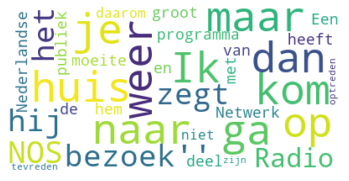

In [ ]:
# Start with one review:
text = ".,,Ik ga naar huis, maar dan kom je weer op bezoek'', zegt hij in het NOS Radio 1-programma Netwerk.\nEen groot deel van de Nederlandse publiek heeft moeite met hem en is daarom niet tevreden over zijn optreden"

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [78]:
def gen2text(gen):
  text = []
  for v in gen:
    text.append(v['generated_text'])

  return text

In [ ]:
def cloudify(text):
  # Create and generate a word cloud image:
  wordcloud = WordCloud(stopwords=stop_words, max_font_size=50, max_words=100, background_color="white").generate(text)

  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

# Vanilla

In [ ]:
from transformers import pipeline

Vanilla = pipeline("text-generation", model="GroNLP/gpt2-small-dutch")

Downloading:   0%|          | 0.00/457M [00:00<?, ?B/s]

# NRC

In [127]:
from transformers import pipeline

NRC = pipeline('text-generation',model='drive/MyDrive/CS/Thesis/GPT2/gpt2-NRC', tokenizer="GroNLP/gpt2-small-dutch")

In [ ]:
NRC("Wat typeert Rutte en de VVD?", max_length=100, num_return_sequences=10)

[{'generated_text': 'Wat typeert Rutte en de VVD? De twee mannen die in 2017 �s lands bekendste politicus waren, gaan op zoek naar een nieuwe lijsttrekker voor hun partij. Maar het is niet altijd mogelijk dat iemand met dezelfde politieke ambities zo�n goed idee heeft als Mark Rutte of Geert Wilders. Dat blijkt dinsdag uit gesprekken tussen informateur Johan Remkes (VVD), fractieleider Wopke Hoekstra (CDA) en demissionair staatssecretaris van Economische Zaken Kajsa Ollongren (D66). Ze hebben'},
 {'generated_text': 'Wat typeert Rutte en de VVD? De ene op de andere dag: �We zijn in het begin van een nieuwe crisis beland�. Dat is wat je hoort bij deze formatiegesprek, dat afgelopen zaterdag werd gehouden tussen oud-ministers Sigrid Kaag (Buitenlandse Zaken) en Herman Tjeenk Willink (Asiel en Migratie). Die waren ook nog steeds bezig als staatssecretaris voor Werkgelegenheid Mark Harbers (, 9/3). \nLees meer in NRC Magazine #1'},
 {'generated_text': 'Wat typeert Rutte en de VVD? In zijn w

In [ ]:
typering = NRC("Wat typeert Rutte en de VVD?", max_length=100, num_return_sequences=10)

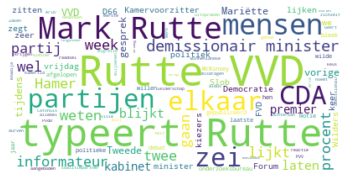

In [ ]:
cloudify(gen2text(typering))

In [ ]:
typering = NRC("Wat typeert Kaag en D66?", max_length=100, num_return_sequences=10)

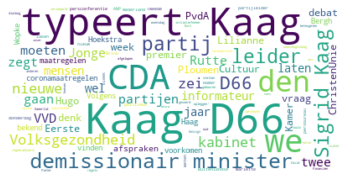

In [ ]:
cloudify(gen2text(typering))

In [ ]:

NRC("Mark Rutte", max_length=100, num_return_sequences=5)

[{'generated_text': 'Mark Rutte, de langst zittende premier van Nederland, is maandag naar het Catshuis voor overleg gegaan met informateur Johan Remkes. Dat melden  op basis van bronnen rond hem. De twee spraken dinsdagochtend in een ingelaste persconferentie over zijn plannen om �de economie weer terug te trekken� en noemde zichzelf �een grote optimist�. Ze benadrukten ook dat ze zich niet willen laten leiden door uitspraken die hij eerder had gezegd tegen demissionair minister Hugo de Jonge (Volks'},
 {'generated_text': 'Mark Rutte, de nieuwe partijleider van de VVD en demissionair minister voor Buitenlandse Zaken, noemt het �extreem pijnlijk� te zijn dat er volgens hem zo weinig mensen zich laten testen vanwege corona. Hij zei zaterdag tijdens een persconferentie: �Er is nu sprake van onzorgvuldig handelen door bewindslieden die in deze situatie verkeren.�Het aantal coronapatiënten op Nederland neemt toe sinds eind augustus naar schatting 2.200 tot 3.600 patiënten per dag. In totaa

In [ ]:
NRC("Hitler", max_length=100, num_return_sequences=5)

[{'generated_text': 'Hitler: �Je zou je kunnen zeggen dat ik op een andere planeet ben beland�. Of: �We hebben er niets aan verbonden, maar het is onze taak om de natuur te verbeteren en we moeten ervoor zorgen dat mensen hun leefomgeving beschermen tegen gevaarlijke stoffen als kanker of ecosysteem.� \nEen deel van dit artikel (10/7) verscheen vorige week bij, waar onder meer wordt besproken hoe klimaatbeleid in Nederland met betrekking tot broeikasgassen moet worden aangepakt'},
 {'generated_text': 'Hitler en rapper Lilianne Ploumen heeft woensdag haar eerste Grammy Award gewonnen. Dat meldt persbureau AP na een livestream van de ceremonie in Los Angeles. De artieste won met het nummer �Radio 2� als beste vrouwelijke artiest, onder wie  (2018) en.De prijsuitreiking was gepland voor maandag 25 april maar is uitgesteld tot op zondag 26 april omdat er nog niet voldoende mensen aanwezig waren om te zien welke artiesten meer nominaties konden ontvangen. Eerder werd ook al bekend'},
 {'gen

In [ ]:
NRC("Joden", max_length=100, num_return_sequences=5)

[{'generated_text': 'Joden zijn niet de enigen in Afghanistan. Het aantal mensen dat zich heeft laten testen op een coronavaccin tegen Covid-19 is vorig jaar licht gedaald, meldt het Wereldgezondheidsorganisatie (WHO). Dat blijkt uit cijfers van het Landelijk Coördinatiecentrum Patiënten Spreiding (LCPS). In 2020 werden ruim 2.750 positieve testuitslagen doorgegeven aan Afghanen en inwoners van zeven landen: Duitsland, Nederland, België, Japan, Canada, Nieuw-Zeeland, Zuid-Afrika'},
 {'generated_text': 'Joden en Palestijnen moeten een einde maken aan geweld in de Palestijnse gebieden door Israël. Dat zegt demissionair premier Ariel Sharon (Defensie, D66) dinsdagavond tegen het persbureau. De Israëlische minister van Buitenlandse Zaken zei dat alle partijen bereid zijn zich te laten gaan onderhandelen over verdere escalatie �op basis van onze ervaringen�.De Verenigde Staten hebben hun banden met Israël niet langer opgebroken nadat er vorige maand twee raketten werden afgeschoten uit Pale

In [ ]:
NRC("De zwarte man", max_length=100, num_return_sequences=5)

[{'generated_text': 'De zwarte man die in 2017 door een politiehond werd aangehouden, is maandag veroordeeld tot twintig jaar celstraf en tbs met dwangverpleging. Dat heeft het Openbaar Ministerie (OM) woensdag laten weten aan . De 58-jarige Afro-Amerikaan zou vorige maand tijdens een controle op de snelweg �maagdrempelig fouilleren� omdat hij te zien was dat agenten zich niet goed konden legitimeren als ze hem naar binnen zouden sturen. Het OM onderzoekt of er strafbare feiten kunnen worden gepleegd'},
 {'generated_text': 'De zwarte man die de politie in Rotterdam heeft gearresteerd op verdenking van moord, is woensdag door een arrestatieteam aangehouden. De 53-jarige verdachte wordt volgens het Openbaar Ministerie veroordeeld tot maximaal drie jaar cel en mag niet meer buiten zijn huis worden verhoord. Het gaat om �onschuldige� misdaden tegen de openbare orde waarbij hij ook betrokken zou zijn geweest bij eerdere pogingen daartoe te saboteren. Dat zei burgemeester Ahmed Aboutaleb vri

In [ ]:
NRC("De witte man", max_length=100, num_return_sequences=5)

[{'generated_text': 'De witte man die zich op de stoep van een supermarkt in Rotterdam had verzameld, is vrijdag veroordeeld tot twaalf jaar celstraf. Dat heeft het gerechtshof Arnhem-Tokee. De rechter oordeelde dat hij schuldig was aan �misleidend en discriminerende uitlatingen tegen vrouwen� (, 3/5). Hij zou ook zijn eigen kinderen hebben misdragen omdat ze geen toegang hadden gehad tot winkels waar klanten welkom waren. Het hof vroeg vrijspraak voor alle delicten waaronder winkeltrucks of horecapatiënten'},
 {'generated_text': 'De witte man van wie ik een jaar geleden al nog nooit had gedacht, is vandaag op 86-jarige leeftijd overleden. Dat heeft het Amerikaanse ministerie van Buitenlandse Zaken  in een verklaring. Het was de derde overlijden die hij zou hebben veroorzaakt tijdens zijn werk als reisorganisator voor onder meer luchtvaartmaatschappijen en andere bedrijven. �Ik ben getroffen door ziekte�, aldus minister Mike Pompeo (Sociale Zaken, Pompeo) tegen persbureau AP.Pompeo zei

In [ ]:
NRC("De linkse politicus", max_length=100, num_return_sequences=5)

[{'generated_text': 'De linkse politicus Thierry Baudet heeft zaterdag zijn ontslag ingediend als partijsecretaris. Dat meldt persbureau ANP maandag op basis van bronnen in de Tweede Kamer die het bericht ontvangen. �Als ik niet goed begrijp wat er precies gaande is, dan heb ik mijn functie tijdelijk neergelegd�, zo zei hij tegen  (lokale) dagblad. De oud-FVD-lijsttrekker werd eerder dit jaar voorgedragen door demissionair premier Mark Rutte en minister Hugo de Jonge na een onderzoek dat onder meer naar antisemitische'},
 {'generated_text': 'De linkse politicus van de Duitse deelstaat Neder-Oostenrijk Sigrid Kaag heeft zaterdag in een tv-toespraak gereageerd op het gewelddadige optreden van haar partijgenoot Wolfgang Schüssel en zijn collega Armin Laschet. Ook zei zij dat hij �een groot gevaar� zou zijn geworden om Oostenrijk te heropenen, zo meldt persbureau ANP. Het is nog geen enkele dagen geleden dat  kanselier Sebastian Kurz (CDU) werd gearresteerd voor openlijke geweldpleging teg

In [ ]:
NRC("De rechtse politicus", max_length=100, num_return_sequences=5)

[{'generated_text': 'De rechtse politicus Jesse Klaver vindt dat het �niet goed� was met de coronapandemie. Dat zei hij in een interview met. De VVD-leider, die als demissionair informateur op 1 juli 2021 werd opgevolgd door Wouter Koolmees (D66) en Pieter Omtzigt (PvdD), heeft zijn eigen woorden: �Het is wel wat mij betreft lastig om te luisteren naar mensen die denken dat je er iets voor moet doen of niet mag laten gaan'},
 {'generated_text': 'De rechtse politicus van de Duitse deelstaat Noordrijn-Westfalen (SPD) Markus Södersen heeft donderdag zijn functie neergelegd. Hij was een vertrouweling van SPD-partijleider Winfried Lichtenberg en zou zich in 2019 hebben laten beïnvloeden door �verboden� coronatoegangsbewijzen op sociale media te verkrijgen. Eerder deze week kwam Södersen, die sinds 2013 lid is van het CDU, nog terug uit opspraak omdat hij seksistisch getinte berichten uitwisselden met andere fractiegenoten.'},
 {'generated_text': 'De rechtse politicus van het Verenigd Konink

In [ ]:
NRC("De vrouw", max_length=100, num_return_sequences=10)

[{'generated_text': 'De vrouw die in oktober vorig jaar werd neergeschoten bij een demonstratie tegen de coronamaatregelen is vrijdagochtend dood aangetroffen op het vliegveld van Kabul. Het Afghaanse ministerie van Volksgezondheid heeft haar lichaam ter plaatse geïdentificeerd, meldt persbureau AFP. Dat melden internationale persbureaus na berichtgeving door lokale bronnen en. Een woordvoerder van de regering zegt dat zij overleed nadat ze zich had voorgedaan te hebben gedragen als �een ongewapende groep�. Ook zijn er berichten over vermaledijde mensen die naar Nederland werden gestuurd om'},
 {'generated_text': 'De vrouw die vorig jaar werd aangehouden in Den Haag, is woensdag door justitie veroordeeld tot vijftien maanden cel en tbs met een dwangverpleging. Dat laat de Haagse rechtbank vrijdag weten  op basis van bronnen rond het Openbaar Ministerie. Zij wordt verdacht van �misleidend handelingen� ten laste gelegd voor haar betrokkenheid bij drugssmokkel tussen 2018 en 2019. De poli

In [ ]:
NRC("De man", max_length=100, num_return_sequences=10)

[{'generated_text': 'De man die op 6 augustus in Den Haag zijn omgekomen bij een auto-ongeluk om het leven heeft zich niet schuldig gemaakt aan de moord. Dat blijkt vrijdag uit  van justitie en Openbaar Ministerie (OM), meldt persbureau ANP. Het ongeluk vond plaats rond 18.30 uur �s avonds tijdens een verkeersopte, waarbij twee personen gewond raakten. Er is nog geen duidelijkheid over wie verantwoordelijk was voor de fatale aanval. De politie onderzoekt naar aanleiding van de zaak wat er mogelijk te gaan gebeuren zou hebben'},
 {'generated_text': 'De man die dinsdag voor de rechtbank in Rotterdam een celstraf van twintig jaar heeft geëist tegen zijn vrouw, is niet vervolgd. Dat melden diverse media op basis van het Openbaar Ministerie (OM). De 37-jarige verdachte wordt ervan verdacht �een minderjarige te hebben misbruikt en  mishandeld� naar aanleiding van seks tussen ze en hem uit 2009. Een dag later werd bekend dat er nog geen sprake was van seksuele intimidatie of seksueel grensove

In [ ]:
NRC("De schuld ligt bij", max_length=100, num_return_sequences=5)

[{'generated_text': 'De schuld ligt bij het OM�s  wegens fraude met de Belastingdienst, zegt demissionair premier Mark Rutte (VVD),. �Het gaat om frauduleus handelen. En ik ga ervan uit dat er op dit moment een grote groep mensen in Nederland die geld hebben verdiend aan belastingontduiking of belastingfraude zijn geworden en dus niet strafrechtelijk vervolgd hoeven worden omdat zij geen bewijs hadden kunnen tonen van strafbare feit�, zei Rutte toen hij vorige week werd benoemd tot nieuwe Tweede Kamervoorzitter'},
 {'generated_text': 'De schuld ligt bij het ministerie van Defensie, die verantwoordelijk is voor de �veiligheidsvoorschriften en veiligheidsbeleid�. Dat heeft demissionair premier Mark Rutte (VVD) dinsdagochtend gezegd in een interview met  op basis van gesprekken met onder andere minister Hugo de Jonge (Volksgezondheid, CDA), oud-staatssecretaris Paul Blokhuis (Binnenlandse Zaken, D66).In zijn verklaring laat De Jonge weten te hebben vernomen dat er momenteel sprake is van 

In [ ]:
NRC("De VVD", max_length=100, num_return_sequences=10)

[{'generated_text': 'De VVD heeft een motie van afkeuring ingediend tegen het plan van de demissionair minister Hugo de Jonge (Volksgezondheid, CDA) om �onvoldoende� coronatoegangsbewijzen aan alle Nederlanders te verlengen. Dat  persbureau ANP vrijdag op basis van. Het is niet duidelijk welke maatregelen De Jonge en andere leden van zijn kabinet hebben genomen die ervoor pleiten dat iedereen vanaf 1 juli maximaal acht dagen toegang kan krijgen tot twee verschillende testlocaties in plaats van één. In totaal zullen er meer dan'},
 {'generated_text': 'De VVD-leider Mark Rutte (VVD) vindt dat er in het demissionaire kabinet �geen enkel verband is� met de moord op Theo van Gogh. Dat zei hij vrijdag tijdens een tv-debat over zijn nieuwe boek  (, 9/6). De Tweede Kamer debatteert donderdagmiddag en wordt volgende week geïnformeerd over welke conclusies daaruit kunnen worden getrokken. Het gaat om twee verdachten die maandag werden veroordeeld tot vier jaar cel, waarvan één voorwaardelijk. Ee

In [ ]:
NRC("D66", max_length=100, num_return_sequences=10)

[{'generated_text': 'D66-Kamerlid Wopke Hoekstra (CDA) heeft vrijdag een interview met informateur Herman Tjeenk Willink afgezegd, omdat hij �niet kan functioneren� op de hoogte is van het kabinetsberaad. Dat maakte Hoekstra  maandagmiddag bekend na berichtgeving in. De CDA-voorman had eerder deze maand nog niet gereageerd op vragen over zijn rol als informateur en wilde weten hoe dat nu verder zal gaan. Hij voegde er bij aan toe: �Ik maak me zorgen om mijn positie'},
 {'generated_text': 'D66-Kamerlid Sjoerd Sjoerdsma heeft donderdag een brief gekregen aan demissionair minister van Volksgezondheid Hugo de Jonge (Volksgezondheid, CDA). Daarin schrijft De Jonge dat �het aantal ziekenhuisopnames als gevolg van Covid-19� in het afgelopen etmaal fors is afgenomen. In totaal zijn zo�n 2.400 nieuwe coronapatiënten op Nederlandse intensivecarebedden behandeld en er liggen momenteel 1.350 patiënten die niet gevaccineerd zijn of positief getest worden'},
 {'generated_text': 'D66 wil een einde ma

In [ ]:
NRC("Het CDA", max_length=100, num_return_sequences=10)

[{'generated_text': 'Het CDA en het ChristenUnie hebben maandag besloten hun steun voor demissionair minister Hugo de Jonge (Volksgezondheid, CDA) in te voeren. Dat blijkt uit een  van informateur Mariëtte Hamer dat dinsdag werd gepubliceerd door. �De twee partijen willen niet met elkaar gaan samenwerken�, zegt Hamer tegen ANP. In tegenstelling tot eerdere verkenners zei De Jonge eerder dit jaar voorstander te zijn van samenwerking: �In plaats daarvan moet we ook onze eigen afweging maken op welke manier'},
 {'generated_text': 'Het CDA heeft de Tweede Kamer gevraagd om een motie van wantrouwen tegen minister Hugo de Jonge (Volksgezondheid, CDA) op te stellen. Aanleiding is het onderzoek dat De Jonge en zijn partij in maart publiceerde waaruit bleek dat zij zich schuldig hebben gemaakt aan �intensief gedrag� bij mensen die voor haar werkten. Dat zegt demissionair staatssecretaris Mona Keijzer (Binnenlandse Zaken, VVD). Het OMT-verzoek werd eerder al ingediend door oud-minister Annemarie

In [ ]:
NRC("In de Nederlandse politiek", max_length=100, num_return_sequences=10)

[{'generated_text': 'In de Nederlandse politiek woedt een conflict tussen demissionair premier Mark Rutte en zijn minister van Buitenlandse Zaken Hugo de Jonge (Volksgezondheid, CDA). De twee spreken elkaar niet eens over. �Ik heb gezegd dat we gaan kijken wat er gebeurt met het aantal mensen die corona-vaccins moeten worden gegeven�, zei Van der Steur maandag op NPO Radio 1 in gesprek met. In Nederland hebben sinds begin juli tientallen nieuwe vaccins nodig om te voorkomen dat ernstige Covid-19'},
 {'generated_text': 'In de Nederlandse politiek woedt een hevig conflict tussen VVD-leider Mark Rutte (VVD) en demissionair minister van Defensie Ank Bijleveld (VRO). Dat blijkt uit  die het kabinet woensdag heeft vrijgegeven. Het is �onjuist� om over te nemen, maar ook omdat Van den Berg nog niet bekend is of hij zich op dit moment beschikbaar zal stellen als verkenner in Kamerdebat De Tweede Kamer wordt vanavond beëdigd.De partijen hebben afgesproken dat ze geen inhoudelijk debat zullen vo

In [ ]:
NRC("Welke politieke partij zou groter moeten worden?", max_length=100, num_return_sequences=5)

[{'generated_text': 'Welke politieke partij zou groter moeten worden? Het antwoord is: geen, maar wel �de grootste�. Dat blijkt uit, een peiling die vrijdag werd gepresenteerd door het Centraal Bureau voor de Statistiek (CBS). In Nederland zijn ruim twee miljoen mensen niet in staat om bij verkiezingen te stemmen en dat aantal schommelt nu tussen één tot acht procent per jaar. De meeste kiezers van CDA-leider Wopke Hoekstra hebben moeite met hun stemgedrag omdat hij op verkiezingsdagen minder invloed uitoefent dan zij'},
 {'generated_text': 'Welke politieke partij zou groter moeten worden? De vraag staat centraal in het nieuwe boek van politicoloog Peter R. de Vries (Universiteit Utrecht). Met zijn artikel �Het is geen toeval dat politici als VVD, CDA of D66 al een paar decennia hebben geregeerd� stelt hij aan alle kanten te willen weten wat er voor hen precies moet gebeuren: hoe ze hun macht en invloed op de samenleving kunnen uitoefenen.R. de Vries heeft zich laten inspireren door ve

In [ ]:
NRC("Wie is de beste politicus van Nederland?", max_length=100, num_return_sequences=5)

[{'generated_text': 'Wie is de beste politicus van Nederland? Het antwoord hangt af van alle factoren die op het Binnenhof zijn voorgelegd, maar je hoeft ook wel iets te vragen. Wie wordt verkozen als �beste kiezer� (van wie  een groot aantal stemmen heeft verloren) moet er eerst bij hebben gekeken wat hij of zij met haar beleid wil en hoe dat kan worden gedaan. In dit hoofdstuk beschrijft NRC-hoofdredacteur Mariëtte Dibbets in gesprek met tien oud-bewindspersonen om hun mening over'},
 {'generated_text': 'Wie is de beste politicus van Nederland? Dat zou je willen zeggen, en dat geldt voor het CDA. In een interview met oud-premier Herman Tjeenk Willink zei informateur Johan Remkes (Volksgezondheid, CDA) onlangs: �Ik kan me voorstellen dat er nog meer Kamerleden zijn die zich op deze manier moeten richten om te kunnen beslissen over wie ik als VVD/D66 premier ben.�In haar partijbestuur schreef demissionair minister Cora van Nieuwenhuizen (Infrastructuur'},
 {'generated_text': 'Wie is de

In [ ]:
NRC("Welke politieke partij heeft de voorkeur van het NRC?", max_length=100, num_return_sequences=5)

[{'generated_text': 'Welke politieke partij heeft de voorkeur van het NRC? Het is nog niet zeker, maar sinds woensdag zijn er zo�n driehonderd reacties binnengekomen op, een opinieonderzoekensite dat onderzoek doet onder meer over politiek en maatschappelijk nieuws. Dat meldt. De meeste lezers reageerden enthousiast: �Wij hebben geen idee waar we mee bezig zijn! We moeten ons nu bezighouden met alle mogelijke onderwerpen die wij als lezer kunnen vinden om deze krant uit te zoeken of naar andere media toe te willen doen aan onze journalistieke taak'},
 {'generated_text': 'Welke politieke partij heeft de voorkeur van het NRC?  is universitair docent geschiedenis en politicologie aan de Radboud Universiteit Nijmegen. Hij schrijft voor, waar hij zich specialiseert tot �homo� (het begrip dat homoseksuele mannen worden genoemd). In zijn column (, 5/11) maakt hij een vergelijking met homoseksualiteit, waarin homofobie wordt gebruikt om homo-reuzen te weren tegen vrouwen die hun seksuele geaar

In [ ]:
NRC("Welke politicus heeft de voorkeur van het NRC?", max_length=100, num_return_sequences=5)

[{'generated_text': 'Welke politicus heeft de voorkeur van het NRC? In zijn column  noemde demissionair minister Wouter Koolmees (Medische Zorg, ChristenUnie) een �mooie vrouw�. Maar dat is niet wat ik wil horen in dit politieke debat over hoe Nederland moet gaan samenwerken met andere Europese landen om te voorkomen dat onze gezondheid ernstig verstoord wordt door coronapas-preventie. Het Europees Geneesmiddelenbureau (EMA) gaat ervan uit dat er meer dan eens 100 miljoen Nederlandse vaccins'},
 {'generated_text': 'Welke politicus heeft de voorkeur van het NRC? En is hij wel een �miljard�, zoals Mark Rutte (VVD) en Wouter Koolmees (D66) zeggen in hun gesprek met Forum voor Democratie (, 18/1). Het antwoord: nee. De meeste partijen hebben geen zin om op zoek te gaan naar, maar juist willen dat ze er ook nog eens aan zijn of haar eigen verkiezingsprogramma worden gepresenteerd. In die categorie staat VVD-lijsttrekker Wopke Hoekstra tegenover D66'},
 {'generated_text': 'Welke politicus he

In [ ]:
NRC("Op wie moet ik stemmen?", max_length=100, num_return_sequences=5)

[{'generated_text': 'Op wie moet ik stemmen? Ik weet niet of dit een vraag hoeft te beantwoorden, maar de afgelopen week is het al duidelijk dat er veel mensen naar mijn stemgedrag zijn gekomen. Dat blijkt donderdag uit nieuwe cijfers van. De opkomst voor �coronapatiënten� kwam in januari met zo�n 4 procent ten opzichte van dezelfde periode twee jaar eerder. Er waren meer dan duizend personen die zich positief testten op Covid-19 (1 miljoen) en -patiënten ('},
 {'generated_text': 'Op wie moet ik stemmen?�, vraagt Mark Rutte in een tv-debat over het coronabeleid. �Ik sta er als kiezer op de eerste rij van mijn stemformat en zie geen andere keus dan te kiezen voor iemand die zich niet weet of hij of haar wil laten vaccineren. Ik heb al zo�n drie keer gevraagd: is dit nou wel echt iets waar mensen tegen elkaar moeten vechten?Het debat begon afgelopen zondag met demissionair premier Mark Rutte (VVD'},
 {'generated_text': 'Op wie moet ik stemmen? Het lijkt me een goed idee om je stembiljet 

In [ ]:
NRC("Op wie moet ik niet stemmen?", max_length=100, num_return_sequences=5)

[{'generated_text': 'Op wie moet ik niet stemmen?�, vraagt de vrouw op een bankje bij het Vondelpark. Ze gaat met haar boodschappentassen mee en zegt: �Dat is echt heel belangrijk!� Maar ze heeft nog geen zin om zo naar buiten te kijken of er iemand anders gestemd zal worden.  En dus wil ze dat niemand zich hoeft te laten zien hoe veel stemhokjes dicht zullen gaan vanwege corona. De gemeente Amsterdam doet dit weekend in samenwerking met lokale GGD�s hun oproep aan'},
 {'generated_text': 'Op wie moet ik niet stemmen? Dat is het thema in, een essay van de Zweedse politicoloog Sigrid Kaag. Ze stelt dat �het enige juiste antwoord op alle politieke en maatschappelijke vraagstukken� mogelijk is, om te beseffen wat er gebeurt als mensen zich weer laten zien hoe ze voor hun vrijheid of veiligheid moeten zorgen. De afgelopen decennia zijn deze kwesties steeds meer aandacht verschoven naar rechts-radicale partijen zoals CUP (Centrumpartij), D66 (Democratische Partij) en'},
 {'generated_text': '

In [ ]:
NRC("Moet ik me laten vaccineren?", max_length=100, num_return_sequences=10)

[{'generated_text': 'Moet ik me laten vaccineren? Het antwoord luidt: nee. Je hebt het nodig om je lichaam te herstellen van de pandemie, een virusuitbraak of andere maatregelen die ervoor zorgen dat mensen niet inenten en hun immuunsysteem overbelast raken. De vaccinatiegraad daalt met steeds minder vaccins per duizend inwoners – zo�n tien procent ten opzichte van 2019. En nu moet iedereen zich bij voorbaat verplicht zijn gevaccineerd tegen Covid-19. Dat blijkt uit'},
 {'generated_text': 'Moet ik me laten vaccineren? Ik kan niet stoppen met de vaccinatie.�Het antwoord op een vraag die bij het RIVM in november werd beantwoord: �Oh ja, je bent toch wel gevaccineerd?�De afgelopen weken waren er meldingen van mensen dat hun eerste prik tegen Covid-19 zou gaan krijgen als ze iets meer dan één keer positief hadden getest en na drie of vier dagen geen klachten kreeg. Dat meldt  dinsdag aan persbureau ANP. Voor zover bekend is dit'},
 {'generated_text': 'Moet ik me laten vaccineren? Dat is ee

In [ ]:
NRC("Zou ik me laten vaccineren?", max_length=100, num_return_sequences=10)

[{'generated_text': 'Zou ik me laten vaccineren? Nee, er zijn nog veel mensen die met een Covid-vaccinatie moeten stoppen. En dat is goed nieuws voor ons land: de vaccinatiegraad in Nederland neemt gestaag toe.  In het laatste kwartaal van vorig jaar waren zo�n 3 miljoen nieuwe coronavaccins ingeënt naar alle waarschijnlijkheid te hebben geleverd aan Nederlandse en andere EU-lidstaten. Het aantal coronabesmettingen schommelt zelfs ten opzichte van dezelfde periode tussen 2003 en 2020'},
 {'generated_text': 'Zou ik me laten vaccineren? Nee. Ik ben geen expert op het gebied van de vaccinatievraagstukken, maar er is een groot verschil tussen mensen die positief zijn en degenen die juist niet gevaccineerd zijn. In ieder geval – zoals in Nederland al vaker wordt uitgelegd – hebben twee verschillende redenen om ze aan te pakken: hun afweerstoornis (de ) of gezondheidsklachten als gevolg van Covid-19. De afgelopen jaren werd duidelijk dat zij veel minder risico lopen'},
 {'generated_text': 'Z

In [ ]:
NRC("Zou ik me aan de corona maatregelen houden?", max_length=100, num_return_sequences=10)

[{'generated_text': 'Zou ik me aan de corona maatregelen houden? Ik denk niet, maar dit is wel een belangrijk moment om te praten met mensen die zich willen laten vaccineren tegen Covid-19. �Het gaat heel anders�, zei demissionair minister Sigrid Kaag (Buitenlandse Zaken, D66) vrijdag tijdens het Catshuisdebat over haar nieuwe coronatoegangsbeleid. Het idee dat alle kinderen vanaf 9 en 10 jaar oud verplicht moeten worden gevaccineerd als ze in eerste instantie'},
 {'generated_text': 'Zou ik me aan de corona maatregelen houden? Het antwoord is altijd: nee. �In Nederland zijn mensen met Covid-19 een stuk of tien keer zoveel mogelijk besmettelijk als in andere landen�, reageert demissionair minister Hugo de Jonge (Volksgezondheid, CDA) vrijdagmiddag op het bericht van. Hij zegt wel dat er nu meer coronamaatregelen nodig zijn voor iedereen die zich onveilig voelt tegenover anderen en ervoor wil zorgen dat ze hun gezondheid veilig kunnen stellen. Dat geldt ook'},
 {'generated_text': 'Zou ik

#Volkskrant

In [ ]:
from transformers import pipeline

Volkskrant = pipeline('text-generation',model='drive/MyDrive/CS/Thesis/GPT2/gpt2-Volkskrant', tokenizer="GroNLP/gpt2-small-dutch")

In [ ]:
Volkskrant("Mark Rutte", max_length=100, num_return_sequences=5)

[{'generated_text': 'Mark Rutte, de VVD-leider en demissionair minister van Financiën: �Ik ben blij dat ik dit moment heb gekozen. Ik kan het niet voorstellen wat er gebeurd zou hebben als we deze crisis weer in elkaar gaan zitten.� Ook premier Mark Rutte (D66) is tevreden over zijn eerste kabinet na bijna een jaar lockdown. �Dit heeft veel te bieden aan mensen die nog steeds geen vaste plek vinden bij hun gemeente of buurt. De coronacrisis was al heel lang voor hen'},
 {'generated_text': 'Mark Rutte: �Ik kan het niet uitleggen, ik zit met een burn-out in mijn hoofd.� De minister van Infrastructuur en Waterstaat (VWS) zei deze week dat hij zijn zorgplannen voor de komende vier jaar nog moet evalueren om te beoordelen of mensen die zich laten vaccineren goed op hun gezondheid kunnen komen. Het kabinet neemt dit besluit vrijdagochtend na overleg met informateur Herman Tjeenk Willink over hoe Nederland verder zal gaan voelen als er meer coronabesm'},
 {'generated_text': 'Mark Rutte, de hu

In [ ]:
Volkskrant("Zou ik me laten vaccineren?", max_length=100, num_return_sequences=10)

[{'generated_text': 'Zou ik me laten vaccineren? �Natuurlijk niet, als je een vaccinatiebewijs in het bezit is. Dat geldt ook voor mensen met ernstige ziekten zoals covid-19 of multivarree�, zegt viroloog Marc Van Dijck van de Wageningen Universiteit (WNU), die al sinds 2018 heeft meegewerkt aan onderzoek naar besmettingsrisico�s bij Nederlandse volwassenen en jonge kinderen. De kans op trombose kan nog oplopen tot ongeveer 2 procent per 100 duizend doses'},
 {'generated_text': 'Zou ik me laten vaccineren? �Het antwoord luidt dat je geen vaccinatiebewijs nodig hebt als je niet gevaccineerd bent. Ik heb nog maar twee weken op het prikbord gestaan, dus ben ik wel aan de pil gegaan.� En zo begint er toch ook over: in Nederland hebben alle coronapas-uitbraken sinds begin oktober bijna allemaal met een positief resultaat kunnen zijn geconstateerd. De meeste meldingen komen bij jongeren en jonge mensen tussen de 15 en 17 jaar (of ouder'},
 {'generated_text': 'Zou ik me laten vaccineren? Het 

In [ ]:
Volkskrant("Zou ik me aan de corona maatregelen houden?", max_length=100, num_return_sequences=10)

[{'generated_text': 'Zou ik me aan de corona maatregelen houden? �Nee hoor. Ik denk dat het virus niet meer zo�n grote impact zal hebben op onze gezondheid als in voorgaande coronavaccins, maar we moeten ervoor zorgen dat er geen onnodige besmettingen ontstaan. Dat geldt voor alle andere producten die wij verkopen: mondkapjes, pilletjes en covid-boostertjes. Er is altijd een kans dat mensen zich weer zullen laten testen of zij wel goed kunnen omgaan met wat ze gaan doen'},
 {'generated_text': 'Zou ik me aan de corona maatregelen houden? �Nee, er zijn geen besmettingen of sterfgevallen. Ik ben gewoon bezig om in te stellen hoeveel mensen het risico krijgen dat hun huisarts een coronapatiënt uit huis wordt gestuurd�, zo schrijft minister Hugo de Jonge (Volksgezondheid) maandag op Twitter. De versoepelingen moeten ook voorkomen dat Nederlanders langer worden blootgesteld aan antisexisico en andere vormen van covid-tablabriculine dan eerder was toegestaan. Het'},
 {'generated_text': 'Zou i

# Trouw

In [ ]:
from transformers import pipeline

Trouw = pipeline('text-generation',model='drive/MyDrive/CS/Thesis/GPT2/gpt2-Trouw', tokenizer="GroNLP/gpt2-small-dutch")

In [ ]:
Trouw("Mark Rutte", max_length=100, num_return_sequences=5)

[{'generated_text': 'Mark Rutte en de minister van binnenlandse zaken, Sigrid Kaag (VVD�s) hebben het afgelopen jaar al gedaan. “We weten nu dat mensen in deze situatie niet goed genoeg voelen om een veilige haven te creëren waar ze kunnen terugkeren naar hun oude huis�, zegt VVD-staatssecretaris Kajsa Ollongren maandag tijdens haar wekelijkse persconferentie op Radio 1. Ze is blij met dit besluit: “Ik vind het erg jammer dat zo snel we hier zijn gekomen.'},
 {'generated_text': "Mark Rutte was al in 2017 minister van financiën. In 2018 werd hij opgevolgd door oud-bewindslieden Mark Rutte en Hedy d'Ancona. “Dat is een grote verandering�, zei de demissionair premier na het overlijden van D66-fractieleider Sigrid Kaag afgelopen maand tijdens haar afscheidsinterview met Trouw. Maar er zijn nog maar weinigen die op dit moment echt iets mee willen doen om hun eigen toekomst te laten leiden. De Tweede Kamer debatteert over"},
 {'generated_text': 'Mark Rutte zei dat hij geen voorstander is van

# Het Parool

In [ ]:
from transformers import pipeline

HetParool = pipeline('text-generation',model='drive/MyDrive/CS/Thesis/GPT2/gpt2-Trouw', tokenizer="GroNLP/gpt2-small-dutch")

In [ ]:
HetParool("Mark Rutte", max_length=100, num_return_sequences=5)

[{'generated_text': 'Mark Rutte heeft de indruk dat hij zich niet zal laten vaccineren. “Er zijn mensen die denken: we kunnen toch vaccinatie doen?�, twitterde VVD-leider Mark Rutte na afloop van een debat over het coronavaccinatiebeleid in Amsterdam. Hij had nog geen concrete plannen voor dit soort besmettingen te overleggen met demissionair minister Hugo de Jonge (Medische Zorg) en staatssecretaris Mariëtte Grabbe (D66). Het kabinet is al weken op zoek naar'},
 {'generated_text': 'Mark Rutte en minister Hugo de Jonge zijn het erover eens, want er is nu nog veel te weinig ruimte voor een nieuwe coalitie met VVD-leider Mark Rutte. “We kunnen geen meerderheid meer krijgen�, legt Kamerlid Pieter Omtzigt (SP). Hij zegt: “In Nederland hebben we maar één partij dat in staat moet worden om onze leiders af te dwingen op iets anders die wij eigenlijk niet willen horen.� De Tweede Kamer wil zo snel mogelijk alle steunbetuigingen'},
 {'generated_text': 'Mark Rutte was de grootste winnaar van het

# General

In [4]:
from transformers import pipeline

General = pipeline('text-generation',model='drive/MyDrive/CS/Thesis/GPT2/gpt2-General', tokenizer="GroNLP/gpt2-small-dutch")

Downloading:   0%|          | 0.00/108 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/957 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/636k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/373k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/63.0 [00:00<?, ?B/s]

In [5]:
General("Mark Rutte", max_length=100, num_return_sequences=5)

[{'generated_text': 'Mark Rutte (VVD) vindt het �een enorme klap� te zijn gegaan. Het demissionaire kabinet heeft voor de tweede keer in jaren een coronavaccinatieprogramma aangekondigd, meldt hij zaterdag op Twitter. De VVD wil dat alle kwetsbare groepen van 18 en ouder gevaccineerd kunnen worden bij hun eerste coronabesmetting. Dat zou volgens hem neerkomen op 3 tot 4 miljoen mensen per jaar. Een deel van deze groep is ook ingeënt onder andere met AstraZeneca'},
 {'generated_text': 'Mark Rutte (VVD, VVD) zei woensdag in een Kamerdebat over de coronamaatregelen op het ministerie van Volksgezondheid niet dat er �op korte termijn� geen versoepeling is gekomen voor kwetsbare groepen. Hij wees erop dat alle scholen en kinderdagverblijven sinds 1 maart dicht moeten worden vanwege corona-risico�s: “Dat zou kunnen betekenen dat we straks nog maar één prik per dag geven bij iedereen die zich ernstig ziek heeft gemaakt of lijdt onder Covid-19'},
 {'generated_text': 'Mark Rutte (VVD) zei dinsda

# Neutral Prompt

In [ ]:
vanilla_gen = Vanilla("X houdt een toespraak", max_length=50, num_return_sequences=10)

[{'generated_text': "X houdt een toespraak.,,Ik ga naar huis, maar dan kom je weer op bezoek'', zegt hij in het NOS Radio 1-programma Netwerk.\nEen groot deel van de Nederlandse publiek heeft moeite met hem en is daarom niet tevreden over zijn optreden"},
 {'generated_text': 'X houdt een toespraak in het midden van de Tweede Kamer.\nVan der Stoel: "We moeten nu eens naar buiten gaan om te kijken of we er iets mee kunnen maken."\nMaandag wordt bekend dat minister Van Mierlo (Buitenlandse Zaken'},
 {'generated_text': "X houdt een toespraak op de dag dat hij met zijn gezin naar het vliegveld is gebracht. Hij wil niet ingaan op kritiek van president Bush, maar heeft ook geen behoefte om te speculeren of er in ieder geval weer verkiezingen zullen plaatsvinden.\n'Ik heb"},
 {'generated_text': 'X houdt een toespraak. "Ik heb geen idee wat er aan het veranderen is in de samenleving", zegt hij,\'maar ik ben zeker niet van plan om hier te wonen".\nDe gemeente Amsterdam heeft zich laten inspirere

In [ ]:
vanilla_gen = [{'generated_text': "X houdt een toespraak.,,Ik ga naar huis, maar dan kom je weer op bezoek'', zegt hij in het NOS Radio 1-programma Netwerk.\nEen groot deel van de Nederlandse publiek heeft moeite met hem en is daarom niet tevreden over zijn optreden"},
 {'generated_text': 'X houdt een toespraak in het midden van de Tweede Kamer.\nVan der Stoel: "We moeten nu eens naar buiten gaan om te kijken of we er iets mee kunnen maken."\nMaandag wordt bekend dat minister Van Mierlo (Buitenlandse Zaken'},
 {'generated_text': "X houdt een toespraak op de dag dat hij met zijn gezin naar het vliegveld is gebracht. Hij wil niet ingaan op kritiek van president Bush, maar heeft ook geen behoefte om te speculeren of er in ieder geval weer verkiezingen zullen plaatsvinden.\n'Ik heb"},
 {'generated_text': 'X houdt een toespraak. "Ik heb geen idee wat er aan het veranderen is in de samenleving", zegt hij,\'maar ik ben zeker niet van plan om hier te wonen".\nDe gemeente Amsterdam heeft zich laten inspireren door zijn ideeën over duurzame energie'},
 {'generated_text': "X houdt een toespraak in de hoop van verzoening, maar hij zegt niet.\nHet is geen schande om te praten over wat er aan de hand is: 'Ik wil graag met je praten.' Ik knik en voel me weergaloos als ik op"},
 {'generated_text': 'X houdt een toespraak, die in het bijzijn van de Amerikaanse president Clinton begint te worden gehouden. "Er is maar één ding wat ik wil zeggen: als we onze grenzen verleggen, moeten wij ervoor zorgen dat deze landen niet met ons meekunnen'},
 {'generated_text': "X houdt een toespraak voor het eerst sinds de Tweede Wereldoorlog. Na afloop zegt hij dat 'de oorlog nog steeds in ons land is'. De Duitse minister van buitenlandse zaken, Hans-Walter Steinmeier (Buitenlandse Handel), heeft eerder deze week"},
 {'generated_text': "X houdt een toespraak voor het einde van de bijeenkomst, maar dat is nu niet gebeurd.\nDe Amerikaanse minister van Defensie Donald Rumsfeld (Buitenlandse zaken) zei op zijn jaarlijkse staatsbezoek aan Washington: 'Ik ben zeer tevreden met onze optreden in"},
 {'generated_text': "X houdt een toespraak in de Tweede Kamer, die op 9 maart wordt gehouden.\nDe VVD-leider zegt dat hij zich 'op zoek naar oplossingen moet gaan'. Hij wijst erop dat er nog veel meer nodig is om het kabinet uit te sluiten over"},
 {'generated_text': "X houdt een toespraak voor de Europese verkiezingen op 11 december. Het wordt nog niet bekend wanneer hij dit keer zal worden ingelast, maar dat komt wel doordat het programma van Eurovisie-programma's en tv-series in Duitsland is stilgelegd.\nHet"}]

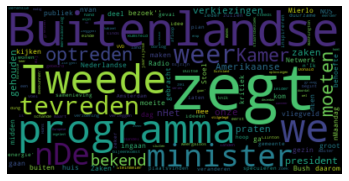

In [ ]:
cloudify(gen2text(vanilla_gen))

In [ ]:
general_gen = General("X houdt een toespraak", max_length=50, num_return_sequences=10)

[{'generated_text': 'X houdt een toespraak voor de Tweede Kamerverkiezingen op 15 november. In zijn speech, getiteld, schrijft hij dat het “belangrijke tijd is om te begrijpen wat wij allemaal moeten denken over onze toekomst en hoe we kunnen leven met deze uitdagingen�'},
 {'generated_text': 'X houdt een toespraak over de ontwikkelingen rondom het coronavirus in zijn hoofdstad, Den Haag. Op sociale media heeft hij kritiek geuit op politici die zich �niet meer bij elkaar� laten onderzoeken of ze coronavaccinaties kunnen gebruiken om te voorkomen dat'},
 {'generated_text': 'X houdt een toespraak in het bijzijn van de Amerikaanse president, Donald Trump (President) en zijn Chinese regeringsadviseur Li Xinghua. �Ik ben zeer blij dat wij deze ontmoeting hebben bereikt�, schrijft Xi op Twitter. De'},
 {'generated_text': 'X houdt een toespraak in de aanloop naar het coronatijd. Het is �het belangrijkste moment om te weten wat er gaande is�, zo heeft premier Mark Rutte vrijdag gezegd bij aflo

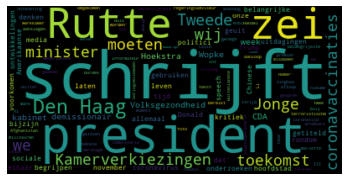

In [ ]:
cloudify(gen2text(general_gen))

In [ ]:
NRC_gen = NRC("X houdt een toespraak", max_length=50, num_return_sequences=10)

[{'generated_text': 'X houdt een toespraak over de toekomst van Nederland. �Wij zijn op zoek naar wat er voor ons ligt�, zegt informateur Mariëtte Hamer (D66) in het eerste kabinet-Rutte III die woensdag aantreedt.'},
 {'generated_text': 'X houdt een toespraak tot de Tweede Kamer over coronavaccins in het buitenland. Dat meldt. De minister-president zegt �grote zorgen� te zijn dat mensen zich niet kunnen beschermen tegen Covid-19 of andere besmettingen,'},
 {'generated_text': 'X houdt een toespraak voor zijn partij in Den Haag. Hij wordt vergezeld door de fractievoorzitters, oud-minister van Defensie Ank Bijleveld (VVD) en Sigrid Kaag (D66). Voor het laatst heeft hij al gezegd dat �'},
 {'generated_text': 'X houdt een toespraak over het coronabeleid voor de Europese Unie. Dit jaar zijn er nog meer dan duizend lidstaten met zo�n coronabesmetting die hun inwoners in aanmerking zouden kunnen komen, zegt EU-voorzitter Ursula von der Leyen'},
 {'generated_text': 'X houdt een toespraak in he

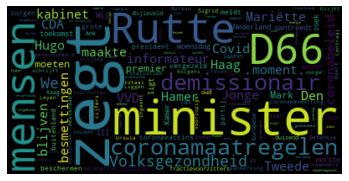

In [ ]:
cloudify(gen2text(NRC_gen))

In [ ]:
Volkskrant_gen = Volkskrant("X houdt een toespraak", max_length=50, num_return_sequences=10)

[{'generated_text': 'X houdt een toespraak op de Dam in Amsterdam-Zuidoost. De nieuwe burgemeester Femke Halsema (VVD): �We hebben geen idee wat we moeten doen als onze stad weer wordt overspoeld door mensen van wie je niet kent.� En: �'},
 {'generated_text': 'X houdt een toespraak. �Ik vind dat het goed gaat voor iedereen�, zei hij zondag tijdens zijn verkiezingsavond in de Amsterdamse stadsdeel Centrum. De partijtop had nog geen idee wat er te doen was met deze coronapandemie'},
 {'generated_text': 'X houdt een toespraak in de Grote Kerk van Amsterdam. �De coronapandemie is voorbij en we zijn nu bezig met deze moeilijke fase�, vertelt hij op Twitter. De nieuwe coronavirus komt niet tot stand omdat er geen vaccin beschikbaar'},
 {'generated_text': 'X houdt een toespraak in het centrum van Beijing, waar de Chinese president Xi Jinping al sinds juni zijn intrek heeft genomen. �We zullen nooit vergeten wat er met hem aan de macht is�, twitterde hij afgelopen zaterdag op Twitter.'},
 {'ge

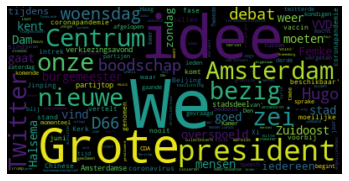

In [ ]:
cloudify(gen2text(Volkskrant_gen))

In [ ]:
Trouw_gen = Trouw("X houdt een toespraak", max_length=50, num_return_sequences=10)

[{'generated_text': 'X houdt een toespraak voor het eerst sinds zijn aantreden in 2018. “Ik ben heel tevreden over wat ik heb gedaan�, schrijft hij op Twitter. Het is niet de enige keer dat premier Rutte en minister van buitenlandse zaken Sigrid K'},
 {'generated_text': 'X houdt een toespraak in het Witte Huis. “Ik ben er niet voor gekomen, maar ik moet wel naar buiten gaan�, aldus president Joe Biden (defensie). Hij zei dit terwijl hij aan de telefoon met premier Mark Rutte'},
 {'generated_text': 'X houdt een toespraak in het centrum van Istanbul, waar hij zich voor de eerste keer uitspreekt over �de strijd om democratie en vrijheid op aarde�. Een paar uur na zijn beëdiging zegt hij nog eens tegen journalisten: “Ik'},
 {'generated_text': 'X houdt een toespraak. “Het is de laatste tijd dat mensen met psychische problemen het gevoel krijgen dat ze op vakantie of in hun werk niet kunnen worden geholpen�, legt hij uit. De afgelopen twee jaar zijn meer dan 70 procent van'},
 {'generated_te

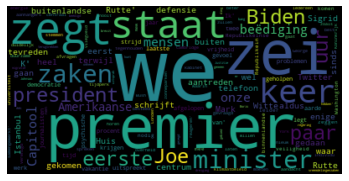

In [ ]:
cloudify(gen2text(Trouw_gen))

In [ ]:
HetParool_gen = HetParool("X houdt een toespraak", max_length=50, num_return_sequences=10)

[{'generated_text': 'X houdt een toespraak over de �hervormingen van onze samenleving�. Hij stelt dat er meer ruimte moet worden voor reflectie op het heden, waarin we ons niet alleen moeten zien of veranderen maar ook beter en gelukkiger maken. In zijn speech'},
 {'generated_text': 'X houdt een toespraak. “In onze tijd hebben we alle vrijheid die er op dit moment is, maar het kan niet anders dan dat mensen hun verantwoordelijkheid moeten nemen voor de gevolgen daarvan�, vertelt ze in gesprek met Het Financieele'},
 {'generated_text': 'X houdt een toespraak op de Dam aan het Binnenhof. In zijn speech staat hij vast: “Het is voor mij belangrijk dat er zoveel mogelijk mensen aanwezig zijn om over te praten met ons�. Het kabinet-Rutte II, die'},
 {'generated_text': 'X houdt een toespraak over de toekomst van zijn land. “Er is weinig veranderd�, zegt premier Mark Rutte in het interview met De Nederlandsche Bank (DNB). “Je zou denken: wat hebben we er nog aan'},
 {'generated_text': 'X houdt

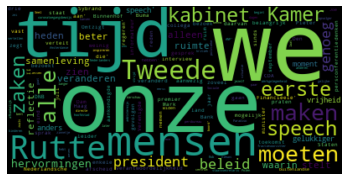

In [ ]:
cloudify(gen2text(HetParool_gen))

# Article rewriting

**Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie** misschien wel „het best uit deze economische crisis komt van de hele westerse wereld”. **Dat zei Mark Rutte (VVD) vrijdag** na afloop van de Eurotop in Brussel tegen persbureau ANP. **Het is een spannende race, zet Rutte,** „maar we zitten in ieder geval in de kopgroep”. **Tegen de achtergrond van de ernstige gevolgen van de coronacrisis** staat Nederland er volgens Rutte „heel goed” voor.

**Na de zomer kunnen landen uitbetaald worden** vanuit het coronaherstelfonds dat de Europese Unie vorig jaar heeft opgetuigd. **Het demissionair kabinet heeft volgens Rutte** nog geen herstelplan opgesteld om naar Brussel te sturen. **Dat moet de nieuwe regering** doen na de formatie. **Volgens de demissionair premier** maakt het niet uit dat het plan nog niet ingediend is. „Dat geld is er gewoon”, zei hij vrijdag. **Als de formatie te lang duurt,** zal het demissionaire kabinet zich er volgens Rutte mogelijk wel over buigen.

## Vanilla

In [ ]:
Vanilla("Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie", max_length=30, num_return_sequences=5)

[{'generated_text': "Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie nog op een andere manier tegemoet. 'Het gaat om"},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie niet meer voor.\nOp een persconferentie zei hij dat'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie nog niet in actie tegen het coronavirus. "We hebben'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie nog in gesprek met het RIVM over een nieuwe aanpak.'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie nog eens uit te spreken over nieuwe maatregelen tegen verspreiding van'}]

In [ ]:
Vanilla("Dat zei Rutte vrijdag", max_length=30, num_return_sequences=5)

[{'generated_text': "Dat zei Rutte vrijdag op een persconferentie in Den Haag: 'Er is niet veel nieuws aan de hand.'\nDe premier had al gezegd dat hij het"},
 {'generated_text': "Dat zei Rutte vrijdag na een debat in de Tweede Kamer. Volgens hem is het kabinet 'een grote stap voorwaarts gegaan'.\nPremier Mark Rutte heeft"},
 {'generated_text': "Dat zei Rutte vrijdag op zijn persconferentie: 'Ik denk wel dat ik er niet aan toe heb nagedacht.'\nIn het NOS-interview benadrukte de premier"},
 {'generated_text': 'Dat zei Rutte vrijdag in het NOS Radio 1 Journaal: "Ik vind dat ik er wel over heb gesproken. Ik ben nu nog niet zo zeker van'},
 {'generated_text': 'Dat zei Rutte vrijdag in een reactie aan de Tweede Kamer.\n"Ik vind het zeer betreurenswaardig dat ik zo\'n politiek gevoelige opmerking maak",'}]

In [ ]:
Vanilla("Het is een spannende race, zet Rutte,", max_length=30, num_return_sequences=5)

[{'generated_text': "Het is een spannende race, zet Rutte, maar ik wil graag met de mensen in het kabinet blijven.'\nDe partij van VVD-leider Mark Rutte"},
 {'generated_text': 'Het is een spannende race, zet Rutte, maar ik hoop dat hij de juiste keuzes kan nemen om het tij te keren. Ik heb mijn twijfels over'},
 {'generated_text': "Het is een spannende race, zet Rutte, maar we zijn daar nog niet klaar voor.'\nPoirot heeft ook kritiek op het kabinetsberaad."},
 {'generated_text': "Het is een spannende race, zet Rutte, maar ik denk er niet uit dat hij het gaat lukken.'\nD66-lijsttrekker Alexander Pechtold heeft"},
 {'generated_text': "Het is een spannende race, zet Rutte, maar ik vind het lastig.'\n'Ik kan me niet voorstellen dat er in dit land iets gebeurt waar"}]

In [ ]:
Vanilla("Tegen de achtergrond van de ernstige gevolgen van de coronacrisis", max_length=30, num_return_sequences=5)

[{'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn veel Nederlanders bang om het leven te redden. In sommige landen hebben mensen die niet in nood verkeren'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is het niet alleen een kwestie van tijd. Er zijn ook nog veel andere dingen te kunnen gebeuren,'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn er tal van nieuwe maatregelen nodig. Het aantal ziekenhuisopnames moet worden teruggebracht naar twee per week,'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is ook dat er niet veel aandacht wordt besteed aan maatregelen voor mensen met een psychische aandoening zoals ADHD'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is er nog iets nieuws te melden. Het aantal coronapandemiegevallen stijgt met een kwart'}]

In [ ]:
Vanilla("Na de zomer kunnen landen uitbetaald worden", max_length=30, num_return_sequences=5)

[{'generated_text': 'Na de zomer kunnen landen uitbetaald worden.\n"Ik denk dat we ons moeten laten zien hoe het gaat", zei Van der Steur in een brief aan'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden, maar ze hoeven er nog niet veel geld voor te betalen.\nDe Europese Centrale Bank (ECB) wil'},
 {'generated_text': "Na de zomer kunnen landen uitbetaald worden. Zo'n 1,9 miljard dollar per jaar is nog niet veel meer dan een kwart van het bruto binnenlands"},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden. Dat geldt niet alleen voor Italië en Frankrijk, maar ook voor alle EU-lidstaten die zich moeten toeleggen'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden.\nOok in Duitsland is het nog steeds lastig om er geld uit te wisselen voor projecten die aan een ander land'}]

In [ ]:
Vanilla("Het demissionair kabinet heeft volgens Rutte", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het demissionair kabinet heeft volgens Rutte en zijn adviseurs de afgelopen twee jaar een overschot van 4,2 miljard euro aan defensie.\nOp dit moment'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte en Kamervoorzitter Arib een plan om de begroting in evenwicht te houden, maar dat is het enige doel.'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte de afgelopen maanden veel te druk uitgeoefend op minister Van der Steur van Veiligheid en Justitie. Het is niet ondenkbaar dat'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte een eigen verantwoordelijkheid genomen. Dat is in strijd met het regeerakkoord dat minister Van Aartsen (VVD) eerder deze week'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte het vertrouwen op de Europese veiligheid in gevaar gebracht. "Ik ben bang dat we daar niet meer zijn."\n'}]

In [ ]:
Vanilla("Dat moet de nieuwe regering", max_length=30, num_return_sequences=5)

[{'generated_text': "Dat moet de nieuwe regering van premier Tsipras nog goedkeuren.'\n'Hij heeft al gezegd dat hij geen akkoord zal komen', zegt correspondent Michel Barnier"},
 {'generated_text': "Dat moet de nieuwe regering ook zijn.'\n'Ja. Maar we hebben het wel een paar maanden geleden besproken en ik ben niet in staat om te"},
 {'generated_text': "Dat moet de nieuwe regering niet doen.'\n'Maar ik geloof dat u het wilt proberen,' zei hij met een zucht. 'Het zou heel goed"},
 {'generated_text': "Dat moet de nieuwe regering wel. Het is nu een kwestie van tijd.'\n'Je hebt gelijk, het lijkt erop dat er iets aan de hand"},
 {'generated_text': 'Dat moet de nieuwe regering van premier Rutte niet zijn geweest. De afgelopen jaren is er nog veel meer over het klimaatbeleid en hoe dat kan worden verbeterd'}]

In [ ]:
Vanilla("Volgens de demissionair premier", max_length=30, num_return_sequences=5)

[{'generated_text': "Volgens de demissionair premier heeft hij niet veel meer te zeggen. 'We hebben geen enkel idee hoe het in Duitsland is.'\nDe SPD-"},
 {'generated_text': 'Volgens de demissionair premier is het nog niet duidelijk of zijn coalitiepartners, VVD en PvdA, akkoord gaan.\nPvdA-leider Diederik Samsom heeft'},
 {'generated_text': "Volgens de demissionair premier is er geen sprake van een'sociale coalities' tussen Nederland en Groot-Brittannië. Premier Blair zegt dat"},
 {'generated_text': 'Volgens de demissionair premier van Frankrijk, Francois Mitterrand, zal dat niet gebeuren. "Het is een politieke crisis", zei hij gisteren in Parijs'},
 {'generated_text': "Volgens de demissionair premier Kok is het nog niet in zicht.,,Ik ben wel blij dat we nu een kabinet hebben gevormd'', zei Dijkstal gisteren"}]

In [ ]:
Vanilla("Als de formatie te lang duurt,", max_length=30, num_return_sequences=5)

[{'generated_text': "Als de formatie te lang duurt, dan kunnen we er niet omheen. Dat is een mooie gedachte.'\n'Dat wil ik ook nog wel,' zei"},
 {'generated_text': "Als de formatie te lang duurt, zal er nog wel sprake van een breuk worden tussen VVD en PVV'er Van den Brink.\nDe PvdA-"},
 {'generated_text': "Als de formatie te lang duurt, kan er ook nog wel wat gebeuren.'\nVan den Berg: 'We hebben het een beetje druk gemaakt. We"},
 {'generated_text': 'Als de formatie te lang duurt, zal er een nieuw kabinet komen", zei minister Van Boxtel van Volkshuisvesting en Ruimtelijke Ordening in reactie.\n'},
 {'generated_text': "Als de formatie te lang duurt, dan zal het nog een paar maanden duren. We zijn er niet helemaal zeker van.'\nVan den Berg: '"}]

##General

In [ ]:
General("Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie", max_length=30, num_return_sequences=5)

[{'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie weer in gesprek over het vaccineren. �We'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie een derde kabinet met �een duidelijke boodschap�'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie in lockdown. De minister van Economische Zaken laat weten'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie een �nieuwe orde� op het gebied van'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie nog eens met �grote zorgen� over het'}]

In [ ]:
General("Dat zei Rutte vrijdag", max_length=30, num_return_sequences=5)

[{'generated_text': 'Dat zei Rutte vrijdag in een debat met informateur Mariëtte Hamer. “Ik begrijp dat er vragen rijzen over de inhoud, maar'},
 {'generated_text': 'Dat zei Rutte vrijdag tijdens een persmoment over het coronabeleid in Den Haag. �Het kabinet wil dat er meer mensen op de intensive care'},
 {'generated_text': 'Dat zei Rutte vrijdag tijdens de wekelijkse ministerraad. De VVD en D66 zouden samen met CDA-Kamerlid Pieter Omtzigt een motie in willen indienen om'},
 {'generated_text': 'Dat zei Rutte vrijdag tijdens een persconferentie. “Ik ben er zeker van dat we het goed kunnen doen�, voegde hij eraan toe.'},
 {'generated_text': 'Dat zei Rutte vrijdag tijdens de Algemene Politieke Beschouwingen. �We gaan er nu weer over praten�, aldus het demissionaire kabinet'}]

In [ ]:
General("Het is een spannende race, zet Rutte,", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het is een spannende race, zet Rutte, �een uitdaging� voor de Nederlandse politiek. De VVD-leider wil dat er op dit moment'},
 {'generated_text': 'Het is een spannende race, zet Rutte, die zich in de Tweede Kamer heeft gestort op �de juiste koers�. De VVD-leider'},
 {'generated_text': 'Het is een spannende race, zet Rutte, maar toch zijn we er al heel lang aan gewend. “We hebben in de afgelopen 24 uur'},
 {'generated_text': 'Het is een spannende race, zet Rutte, maar hij heeft er wel genoeg van. “Maar de vraag is: wat hebben we gewonnen?'},
 {'generated_text': 'Het is een spannende race, zet Rutte, en dan gaat het even stil. Het lijkt erop dat de premier niet van plan is zich te laten vaccin'}]

In [ ]:
General("Tegen de achtergrond van de ernstige gevolgen van de coronacrisis", max_length=30, num_return_sequences=5)

[{'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is het niet verwonderlijk dat veel mensen met een chronische ziekte worden gevaccineerd. Dat blijkt uit onderzoek'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn er ook veel zorgen. “Het is voor ons allemaal een zware bevalling�,'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn tal van maatregelen te versoepelen, zegt demissionair minister Wopke Hoekstra (Financiën'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis, dat in veel gevallen ook voor kinderen en jonge volwassenen is. Zo�n 80 procent van'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is nog veel te zien. In het afgelopen jaar zijn er meer dan 100 duizend nieuwe besmettingen gemeld'}]

In [ ]:
General("Na de zomer kunnen landen uitbetaald worden", max_length=30, num_return_sequences=5)

[{'generated_text': 'Na de zomer kunnen landen uitbetaald worden in het coronatoegangsbewijs. Wie een negatieve testuitslag heeft, kan zich laten vaccineren als dat veilig is'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan het aantal coronabesmettingen in Nederland. Dat demissionair minister Hugo de Jonge (Volksgezondheid, CDA'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan coronavaccins. Dat meldt het Centraal Bureau voor de Statistiek (CBS) vrijdagochtend op basis van cijfers'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan mensen die hun baan hebben opgegeven. Dat heeft premier Mark Rutte (VVD) woensdag bekendgemaakt, meldt persbureau ANP.'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan migranten die uit Afghanistan hebben verdreven. Dat heeft premier Justin Trudeau dinsdag gezegd in een toespraak, melden internationale'}]

In [ ]:
General("Het demissionair kabinet heeft volgens Rutte", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het demissionair kabinet heeft volgens Rutte �nog niet� besloten tot versoepelingen van het coronamaatregelen. Dat liet premier Mark Rutte'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte en D66 een �grote stap voorwaarts gezet� gemaakt in het aanpakken van de toeslagenaffaire.'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte �ernstige plannen� gemaakt om het aantal coronapatiënten in Nederland te verminderen. Dat'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte nog niet besloten wat er in het nieuwe regeerakkoord precies moet komen. Dat blijkt uit een brief naar Tweede Kamervoorzitter'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte en de Kamer ingestemd met het invoeren van een coronamaatregelenpakket. Dat maakte premier Mark Rutte (VVD'}]

In [ ]:
General("Dat moet de nieuwe regering", max_length=30, num_return_sequences=5)

[{'generated_text': 'Dat moet de nieuwe regering van Myanmar, die eerder dit jaar aantrad als interim-president, nu nog eens aanstellen. Volgens het Myanmare'},
 {'generated_text': 'Dat moet de nieuwe regering-Rutte IV in een week tijd besluiten. De demissionaire minister van Buitenlandse Zaken Stef Blok (ChristenUnie)'},
 {'generated_text': 'Dat moet de nieuwe regering-Rutte III van Rutte en D66 hebben opgeleverd. Dat zei demissionair minister Kajsa Ollongren (Binnen'},
 {'generated_text': 'Dat moet de nieuwe regering wel lukken. �We hebben het afgelopen jaar zo�n 1,8 miljard euro nodig om dit land te redden'},
 {'generated_text': 'Dat moet de nieuwe regering in het bijzonder doen, zei demissionair premier Mark Rutte maandag na een debat met informateur Mariëtte Hamer.'}]

In [ ]:
General("Volgens de demissionair premier", max_length=30, num_return_sequences=5)

[{'generated_text': 'Volgens de demissionair premier heeft het �heel zwaar� op zich genomen en zal er geen enkele versoepeling van coronamaatregelen worden'},
 {'generated_text': 'Volgens de demissionair premier, Sigrid Kaag (D66), is het tijd voor een nieuw kabinet. Dat heeft ze woensdagavond bekendgemaakt op Twitter'},
 {'generated_text': 'Volgens de demissionair premier is het aantal coronabesmettingen en ziekenhuisopnames in Nederland al sinds eind maart met 2,9 procent gedaald. Dat'},
 {'generated_text': 'Volgens de demissionair premier wordt er een nieuw kabinet opgericht om te zorgen dat meer mensen zich laten vaccineren. Dat heeft minister van Volksgezondheid Hugo de'},
 {'generated_text': 'Volgens de demissionair premier is het aantal coronapatiënten dat op een ICafspraak in Amsterdam opgenomen moet worden �overvol�'}]

In [ ]:
General("Als de formatie te lang duurt,", max_length=30, num_return_sequences=5)

[{'generated_text': 'Als de formatie te lang duurt, is het dan ook tijd dat we een nieuw kabinet vormen. De huidige premier Mark Rutte kan nog steeds rekenen op steun'},
 {'generated_text': 'Als de formatie te lang duurt, dan is er geen sprake van een nieuw kabinet. Dat zei demissionair minister De Jonge (Volksgezondheid, CDA'},
 {'generated_text': 'Als de formatie te lang duurt, is dat voor VVD en D66 niet verwonderlijk. Beide partijen zijn bezig met “veranderend�'},
 {'generated_text': 'Als de formatie te lang duurt, komt er een einde aan het politieke leven. Er zijn twee partijen die met elkaar kunnen praten: VVD en D66'},
 {'generated_text': 'Als de formatie te lang duurt, dan komt er nog eens een nieuwe premier. De VVD-kiezers hebben al genoeg van Rutte en zijn kabinet'}]

## NRC

In [ ]:
NRC("Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie", max_length=30, num_return_sequences=5)

[{'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie weer terug op het normale leven. Dat meldt persbureau ANP'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie op een nieuw hoogtepunt. Dat heeft het kabinet woensdag bekendgemaakt'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie weer tot bezinning over het coronavirus. Dat zei hij tijdens'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie nog steeds in lockdown. �Dit is een'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie een nieuw kabinet. Dat zei hij tijdens het Catshuis'}]

In [ ]:
NRC("Dat zei Rutte vrijdag", max_length=30, num_return_sequences=5)

[{'generated_text': 'Dat zei Rutte vrijdag tijdens een persmoment over de coronapandemie. �Daar ben ik van overtuigd en dat is wel zo�'},
 {'generated_text': 'Dat zei Rutte vrijdag na afloop van de ministerraad  �heel erg goed� over het coronabeleid. Hij is op zoek naar een nieuwe'},
 {'generated_text': 'Dat zei Rutte vrijdag na afloop van de eerste ministerraad: �Ik ben er niet om aan te denken.� Dat was een grapje, maar'},
 {'generated_text': 'Dat zei Rutte vrijdag tegen journalisten. �Wij staan op de valreep van een nieuwe crisis�, zo schreef hij in het tv-programma'},
 {'generated_text': 'Dat zei Rutte vrijdag na afloop van de Algemene Politieke Beschouwingen (, 22/7). Hij benadrukte dat we ons �heel goed� moeten'}]

In [ ]:
NRC("Het is een spannende race, zet Rutte,", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het is een spannende race, zet Rutte, Klaver en Wilders op de juiste weg naar het parlement. Het lijkt erop dat VVD-leider Mark Rutte ('},
 {'generated_text': 'Het is een spannende race, zet Rutte, Klaver en D66 op scherp in de aanval. �Ik weet zeker dat dit het belangrijkste verkiezingsdebat'},
 {'generated_text': 'Het is een spannende race, zet Rutte, D66 en het CDA de achtervolging in om te gaan regeren. �Ik wil niet zeggen dat ik'},
 {'generated_text': 'Het is een spannende race, zet Rutte, maar het kan toch niet anders. Een week na de Tweede Kamerverkiezingen wordt er opnieuw �opnieuw�'},
 {'generated_text': 'Het is een spannende race, zet Rutte, D66 en ChristenUnie in de weg. Het gaat om  �de grootste coalitie van Europa�'}]

In [ ]:
NRC("Tegen de achtergrond van de ernstige gevolgen van de coronacrisis", max_length=30, num_return_sequences=5)

[{'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn in het Verenigd Koninkrijk ruim 2.800 coronagevallen gemeld. Dat heeft demissionair premier'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn veel mensen positief getest op corona.  Dat meldt het Rijksinstituut voor Volksgezondheid en Milieu (R'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn tal van positieve ontwikkelingen te zien op het gebied van coronatests. Dat blijkt vrijdag uit'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn er steeds nieuwe maatregelen te overwegen. Dat laat het ministerie van Volksgezondheid, Welzijn en Sport ('},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn er grote demonstraties in Den Haag. Dat melden  woensdag op basis van informatie die demissionair'}]

In [ ]:
NRC("Na de zomer kunnen landen uitbetaald worden", max_length=30, num_return_sequences=5)

[{'generated_text': 'Na de zomer kunnen landen uitbetaald worden voor coronavaccins. Dat heeft het demissionaire kabinet woensdag  in een persconferentie, zo meldt persbureau ANP'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan coronapatiënten. Dat zegt een woordvoerder van het Internationale Patiëntenfederatie (ICF). Het ICF'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan coronapatiënten dat in een ziekenhuis verblijven, zo heeft het Internationaal Monetair Fonds (IMF).'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan coronavaccins, zo heeft het Amerikaanse ministerie van Volksgezondheid donderdag. Dat meldt persbureau Reuters. In totaal krijgen'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan coronapatiënten die in het buitenland verblijven. Dat heeft premier Mark Rutte (VVD) woensdag gezegd tijdens een'}]

In [ ]:
NRC("Het demissionair kabinet heeft volgens Rutte", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het demissionair kabinet heeft volgens Rutte III de �stabiliteitsagenda� bereikt in het buitenland. Dat melden internationale persbureaus op basis'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte III nog maar twee jaar aan te sluiten, omdat de coronamaatregelen onvoldoende zijn om het aantal besmettingen'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte III ingestemd met het versoepelingen van coronamaatregelen bij evenementen en concerten. Dat meldt persbureau ANP op basis'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte een �grote kans� op de vorming van een nieuwe regering, zo laat het Rijksinstituut voor Volksgezondheid'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte �heel goede hoop� te hebben gedaan om  het coronavaccin van Pfizer en BioN'}]

In [ ]:
NRC("Dat moet de nieuwe regering", max_length=30, num_return_sequences=5)

[{'generated_text': 'Dat moet de nieuwe regering in Den Haag niet meer doen. Dat laat demissionair minister van Defensie Ank Bijleveld (Defensie, VVD'},
 {'generated_text': 'Dat moet de nieuwe regering van premier Mark Rutte zijn. Dat zei hij in een interview met. �In het huidige kabinet worden we nog niet eens'},
 {'generated_text': 'Dat moet de nieuwe regering-Ruimtelijke Ordening, die donderdag in het kabinet wordt geïnstalleerd, wel eens worden goedgekeurd. Dat heeft demissionair'},
 {'generated_text': 'Dat moet de nieuwe regering van premier Boris Johnson (Rutte III) wel lukken om het klimaatakkoord van Parijs te bereiken. Dat heeft demissionair'},
 {'generated_text': 'Dat moet de nieuwe regering van president Donald Trump zijn. Dat zei demissionair minister Hugo de Jonge (Volksgezondheid, CDA) donderdag na afloop van'}]

In [ ]:
NRC("Volgens de demissionair premier", max_length=30, num_return_sequences=5)

[{'generated_text': 'Volgens de demissionair premier Mark Rutte (VVD) is het �ernstigst getroffen� om te voorkomen dat burgers die in coronat'},
 {'generated_text': 'Volgens de demissionair premier Mark Rutte (VVD) is het coronabeleid niet meer nodig. In een gesprek met informateur Mariëtte H'},
 {'generated_text': 'Volgens de demissionair premier Mark Rutte (VVD) is er een tekort aan bedden van coronavaccinaties. �Dat betekent niet dat we'},
 {'generated_text': 'Volgens de demissionair premier Mark Rutte (VVD) en staatssecretaris Mona Keijzer (Medische Zorg, CDA) is er geen sprake van �'},
 {'generated_text': 'Volgens de demissionair premier Mark Rutte (VVD) en zijn collega�s in Den Haag is een nieuw kabinet mogelijk. De ministers van Financiën'}]

In [ ]:
NRC("Als de formatie te lang duurt,", max_length=30, num_return_sequences=5)

[{'generated_text': 'Als de formatie te lang duurt, zal er nog steeds wel een coalitie ontstaan tussen PvdA-lijsttrekker Asscher en CDA-leider Wopke Hoekstra.'},
 {'generated_text': 'Als de formatie te lang duurt, wordt er een nieuw kabinet gevormd. Dat maakte premier Rutte  dinsdag bekend aan het begin van zijn persconferentie –'},
 {'generated_text': 'Als de formatie te lang duurt, zal een meerderheid in het Tweede Kamer zijn. Dat zei demissionair minister van Binnenlandse Zaken Kajsa Ollongren'},
 {'generated_text': 'Als de formatie te lang duurt, is er in ieder geval een nieuw kabinet nodig. Dat heeft het Centraal Bureau voor de Statistiek (CBS) donderdag laten'},
 {'generated_text': 'Als de formatie te lang duurt, zal er een einde komen aan het kabinetsbeleid. �We zijn niet klaar�, zei demissionair'}]

## Volkskrant

In [ ]:
Volkskrant("Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie", max_length=30, num_return_sequences=5)

[{'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie al in actie. �Dit is een historisch moment'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie een jaar of twee terug bij het aantal besmettingen.'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie een jaar lang niet verder dan 1.500 besmettingen'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie in lockdown te vervallen. In plaats van een �'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie weer in beeld. �Er is een einde gekomen'}]

In [ ]:
Volkskrant("Dat zei Rutte vrijdag", max_length=30, num_return_sequences=5)

[{'generated_text': 'Dat zei Rutte vrijdag in een verklaring na afloop van de kabinetsvergadering. �Er zijn nog veel mensen die het niet willen�, hij voegde'},
 {'generated_text': 'Dat zei Rutte vrijdag tijdens een persconferentie in het Catshuis. �We laten weten dat we dit niet langer kunnen doorgaan�, aldus de premier'},
 {'generated_text': 'Dat zei Rutte vrijdag in een toelichting aan de Algemene Politieke Beschouwingen (APB). Hij voegde daaraan toe dat er �grote zorgen�'},
 {'generated_text': 'Dat zei Rutte vrijdag tijdens de Algemene Politieke Beschouwingen (APB). �Er is iets wat we in Nederland hebben geleerd.� De'},
 {'generated_text': 'Dat zei Rutte vrijdag na een debat in het Kamerdebat met de demissionair staatssecretaris van Financiën (Financiën). �Ik ben ervan overtuigd dat'}]

In [ ]:
Volkskrant("Het is een spannende race, zet Rutte,", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het is een spannende race, zet Rutte, D66-leider Sigrid Kaag en zijn secondanten op het verkeerde been. De formatie van de'},
 {'generated_text': 'Het is een spannende race, zet Rutte, D66 en ChristenUnie op hun kop. Het was voor het eerst in bijna tien jaar tijd dat de formatie'},
 {'generated_text': 'Het is een spannende race, zet Rutte, zijn vrouw en de hele natie op hun schreden terug. �Ik weet het niet�, zegt'},
 {'generated_text': 'Het is een spannende race, zet Rutte, Klaver en D66 in de verkeerde richting. Het lijkt alsof iedereen zich afvraagt waarom het niet goed komt om'},
 {'generated_text': 'Het is een spannende race, zet Rutte, Klaver en D66 in de eerste helft van het jaar hun eigen koers aan. �Op dit moment'}]

In [ ]:
Volkskrant("Tegen de achtergrond van de ernstige gevolgen van de coronacrisis", max_length=30, num_return_sequences=5)

[{'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn er in Nederland meer dan 150 duizend besmettingen per dag. Het aantal nieuwe coronabesmettingen'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is het nog steeds lastig om een nieuw kabinet tot stand te brengen. Er staan al twee partijen die'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis hebben veel mensen zich afgevraagd of het mogelijk was dat ze na corona alsnog een uitkering zouden kunnen krijgen.'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis hebben we al een tijdje niet veel tijd om over te schrijven. Maar nu gaat het ook heel anders'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is er veel onrust in Nederland. De coronamaatregelen worden door het kabinet al aangekondigd, maar'}]

In [ ]:
Volkskrant("Na de zomer kunnen landen uitbetaald worden", max_length=30, num_return_sequences=5)

[{'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan het ministerie van Financiën. Het geld komt niet direct uit, maar is bedoeld voor mensen die in aanmerking komen voor'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan burgers die hun leven in een ander land hebben geruïneerd. Nu is dat niet gebeurd, blijkt uit cijfers'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden. Dat is niet alleen mogelijk dankzij het coronabeleid, maar ook door �de� versoepelingen die'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden in euro�s. Het was al een verrassing toen het Amerikaanse ministerie van Financiën (BON) dit jaar'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden voor �s werelds meest vervuilende industrie. Dat is niet te verwachten als er geen maatregelen zijn om die uitstoot'}]

In [ ]:
Volkskrant("Het demissionair kabinet heeft volgens Rutte", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het demissionair kabinet heeft volgens Rutte al een plan om de coronapandemie op te pakken. Maar als dat niet lukt, moet het'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte en D66 afgesproken dat het aantal coronabeleid-besmettingen de komende weken nog zal stijgen. De'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte en zijn collega�s afgesproken dat alle coronabeleidmaatregelen die de afgelopen twee weken gelden, zullen worden'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte al ingestemd met versoepelingen. Het CDA, de VVD en D66 willen dat er in 2050 zo�'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte de komende tijd een aantal maatregelen aangekondigd om te voorkomen dat het stikstofprobleem opnieuw kan worden opgelost. Een groot deel'}]

In [ ]:
Volkskrant("Dat moet de nieuwe regering", max_length=30, num_return_sequences=5)

[{'generated_text': 'Dat moet de nieuwe regering-Biden dinsdag weten. �Ik begrijp dat we er nog een paar maanden mee moeten maken�, zei hij'},
 {'generated_text': 'Dat moet de nieuwe regering-Biden wel lukken om het land weer op orde te maken. �Ik kan er nog niet bij neerleggen�'},
 {'generated_text': 'Dat moet de nieuwe regering van premier Rutte, die eerder dit jaar als minister van Economische Zaken onder druk kwam te staan uit onvrede over het coronamaat'},
 {'generated_text': 'Dat moet de nieuwe regering-Biden hebben gezegd tijdens zijn persconferentie in Washington. �Maar ik vrees dat we er niet over zullen praten�'},
 {'generated_text': 'Dat moet de nieuwe regering van premier Rutte doen, stelt minister Hugo de Jonge (Volksgezondheid) in een woensdag verschenen rapport aan het Tweede Kamer. De'}]

In [ ]:
Volkskrant("Volgens de demissionair premier", max_length=30, num_return_sequences=5)

[{'generated_text': 'Volgens de demissionair premier is het aantal coronapandemie-patiënten in Nederland met zo�n 60 procent gestegen sinds vorige week.'},
 {'generated_text': 'Volgens de demissionair premier is het aantal coronavaccinatiegevallen fors gedaald. De vaccinatiegraad steeg met 2 procent ten opzichte van dezelfde periode vorig'},
 {'generated_text': 'Volgens de demissionair premier Rutte en minister van Buitenlandse Zaken Ank Bijleveld (Buitenlandse zaken) wordt het �heel druk� om'},
 {'generated_text': 'Volgens de demissionair premier is er sprake van een �destructieve lockdown�, aldus Rutte. Maar hij wijst erop dat het'},
 {'generated_text': 'Volgens de demissionair premier is er een einde aan het kabinet, maar dat gaat nog altijd door. �De Kamer heeft zich vergist�'}]

In [ ]:
Volkskrant("Als de formatie te lang duurt,", max_length=30, num_return_sequences=5)

[{'generated_text': 'Als de formatie te lang duurt, moet een nieuwe leider in het kabinet gaan staan. Dat is volgens VVD-leider Syrias Schimmelpenn'},
 {'generated_text': 'Als de formatie te lang duurt, kan het er nog niet worden. De PvdA-lijsttrekker Diederik Samsom en zijn coalitiepartner Jan Peter Balkenende weten dat'},
 {'generated_text': 'Als de formatie te lang duurt, moet er een nieuwe regering worden gevormd. En dat zou volgens het CDA – in tegenstelling tot vorige kabinetten �'},
 {'generated_text': 'Als de formatie te lang duurt, is er nu wel iets misgegaan. De partij van D66-voorman Sigrid Kaag (Binnenlandse Zaken)'},
 {'generated_text': 'Als de formatie te lang duurt, zal er nog maar één kandidaat worden gekozen die een duidelijke positie in het bestuurscultuur wil versterken. De oud-'}]

## Trouw

In [ ]:
Trouw("Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie", max_length=30, num_return_sequences=5)

[{'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie nog niet met een nieuw kabinet. “We'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie weer op het juiste spoor. “Dit is'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie nog in lockdowns terecht. “We'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie op zoek naar een nieuwe leider. In plaats daarvan is'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie nog een tijd lang in lockdowns –'}]

In [ ]:
Trouw("Dat zei Rutte vrijdag", max_length=30, num_return_sequences=5)

[{'generated_text': 'Dat zei Rutte vrijdag tijdens de wekelijkse persconferentie. “Ik denk dat we er een beetje van moeten maken�, hij voegde eraan toe.'},
 {'generated_text': 'Dat zei Rutte vrijdag na afloop van de ministerraad, in een interview met Radio 1. “Er is wel degelijk vooruitgang geboekt�, zegt'},
 {'generated_text': 'Dat zei Rutte vrijdag in een Kamerbrief aan minister Arie Slob. “Ik heb er wel begrip voor, maar het is ook belangrijk dat we'},
 {'generated_text': 'Dat zei Rutte vrijdag tijdens de persconferentie in het Catshuis. “Ik wil zeggen dat ik denk dat wij er nog heel wat van hebben�'},
 {'generated_text': 'Dat zei Rutte vrijdag in een tv-toespraak. “Ik weet het al heel goed, maar dat kan niet anders.� Hij'}]

In [ ]:
Trouw("Het is een spannende race, zet Rutte,", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het is een spannende race, zet Rutte, D66 en CDA op zich af om de formatie in te voeren. “Ik ben blij dat'},
 {'generated_text': 'Het is een spannende race, zet Rutte, die in zijn eerste regeerperiode al zeven jaar aan het werk was als minister van Economische Zaken. Op de'},
 {'generated_text': 'Het is een spannende race, zet Rutte, zijn ministers en premier Mark Rutte voor elkaar in om het kabinet te laten zien dat er wel iets aan de'},
 {'generated_text': 'Het is een spannende race, zet Rutte, die in zijn derde termijn ook als premier de langstzittende VVD-leider ooit op rij staat. De'},
 {'generated_text': 'Het is een spannende race, zet Rutte, D66 en GroenLinks er samen in de peilingen. Die partijen gaan naar het noorden van Europa om zich heen'}]

In [ ]:
Trouw("Tegen de achtergrond van de ernstige gevolgen van de coronacrisis", max_length=30, num_return_sequences=5)

[{'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is een nieuw onderzoek door het Centrum voor Strategische Engineering (CSA) dat in opdracht'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn er ook nog veel mensen te weinig om zich heen, laat het RIVM weten. “'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is nog niet duidelijk. “Voor zover bekend zijn er meer dan honderd coronatijd�'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis heeft het ministerie van VWS maandag bekendgemaakt dat er in totaal ruim 200 miljoen euro beschikbaar moet worden voor'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis hebben we nog weinig tijd. De afgelopen tien jaar is dat aantal gestegen door het coronapandem'}]

In [ ]:
Trouw("Na de zomer kunnen landen uitbetaald worden", max_length=30, num_return_sequences=5)

[{'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan migranten die vanuit Griekenland naar Nederland moeten komen. Maar dat is niet voldoende, zegt een woordvoerder van het Griekse ministerie'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan mensen die in het buitenland wonen. Het ministerie van buitenlandse zaken wil dat �s werelds grootste donorlanden'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden in bitcoins of andere valuta. Maar nu zijn er al meer regels nodig, stelt een woordvoerder van ABN Amro'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan mensen die in Nederland verblijven. “We krijgen nu al veel aanvragen, maar ik heb er geen idee'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden in het Internationaal Monetair Fonds. Dat is een bedrag van bijna 1 miljard dollar (2,1 miljard euro)'}]

In [ ]:
Trouw("Het demissionair kabinet heeft volgens Rutte", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het demissionair kabinet heeft volgens Rutte al een aantal maatregelen aangekondigd, waaronder meer coronapatiënten te maken met corona-risico�s.'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte niet genoeg tijd nodig. De eerste stappen zijn te volgen, zo blijkt uit de cijfers van het Centraal Bureau voor'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte en Kamervoorzitter Aung San Suu Kyi gevraagd de komende drie jaar het geldkraan uit te draaien om'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte een aantal maatregelen te nemen om het klimaatbeleid in stand te brengen, maar hij is niet optimistisch. �'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte �een heel moeilijke periode doorgemaakt�, omdat er nog niet een einde was aan de lockdown.'}]

In [ ]:
Trouw("Dat moet de nieuwe regering", max_length=30, num_return_sequences=5)

[{'generated_text': 'Dat moet de nieuwe regering van president-Bush worden, maar hij heeft er geen idee hoe dat precies is. Het ministerie van buitenlandse zaken liet weten'},
 {'generated_text': 'Dat moet de nieuwe regering wel lukken. In het eerste kwartaal van 2021 is er sprake van 3,4 miljard euro aan extra uitgaven voor onderwijs en gezondheidszorg'},
 {'generated_text': 'Dat moet de nieuwe regering van premier Mark Rutte, die in zijn eerste regeringsverklaring al aangaf dat het “een goed idee� was om'},
 {'generated_text': 'Dat moet de nieuwe regering van premier Rutte weten. “Ik weet het nog niet, maar ik denk dat we wel kunnen helpen�,'},
 {'generated_text': 'Dat moet de nieuwe regering van president Bashar al-Assad doen, maar in het uiterste geval is er niet veel veranderd. “De'}]

In [ ]:
Trouw("Volgens de demissionair premier", max_length=30, num_return_sequences=5)

[{'generated_text': 'Volgens de demissionair premier Mark Rutte heeft “een grote stap voorwaarts gezet� gemaakt, zo liet hij in een persverklaring weten.'},
 {'generated_text': 'Volgens de demissionair premier is het niet nodig om te beginnen met een kabinetscrisis, zoals eerder deze week. “De tijd lijkt rijp'},
 {'generated_text': 'Volgens de demissionair premier Mark Rutte is dat �onacceptabel�. De coronamaatregelen, die door het kabinet tot nu toe'},
 {'generated_text': 'Volgens de demissionair premier Mark Rutte gaat het een stuk anders dan eerder gezegd. “Ik kan me niet voorstellen dat er op dit moment'},
 {'generated_text': 'Volgens de demissionair premier wordt er een nieuwe coalitie gevormd, maar dat is in ieder geval niet zo eenvoudig als gedacht. “We hebben'}]

In [ ]:
Trouw("Als de formatie te lang duurt,", max_length=30, num_return_sequences=5)

[{'generated_text': 'Als de formatie te lang duurt, is dat nog een stuk lastiger. “We hebben heel weinig vertrouwen in onze leiders�, zei dem'},
 {'generated_text': 'Als de formatie te lang duurt, moet er een einde komen aan het kabinetsperiode waarin nog steeds grote onzekerheid is ontstaan over wat daar precies mee gaat gebeuren'},
 {'generated_text': 'Als de formatie te lang duurt, komt er nog eens een nieuw kabinet-Rutte II in. Het gaat om twee kabinetten: die van Rutte III'},
 {'generated_text': 'Als de formatie te lang duurt, is het ook niet ondenkbaar dat er een nieuw kabinet van VVD�ers wordt gevormd. Rutte en D66 willen'},
 {'generated_text': 'Als de formatie te lang duurt, komt er bij het vertrek van CDA-lijsttrekker Brinkman ook nog eens iets anders. “Ik voel me'}]

## Het Parool

In [ ]:
HetParool("Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie", max_length=30, num_return_sequences=5)

[{'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie weer in het nieuws. Hij zei dat “'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie met een plan. “Het is belangrijk dat'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie een beetje op vooruit, zegt hij. “'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie weer terug met een tweede kabinet. “We'},
 {'generated_text': 'Volgens demissionair premier Mark Rutte (VVD) komt Nederland na de coronapandemie een nieuw kabinet op gang. Hij zei donderdag dat hij'}]

In [ ]:
HetParool("Dat zei Rutte vrijdag", max_length=30, num_return_sequences=5)

[{'generated_text': 'Dat zei Rutte vrijdag in een persconferentie aan het einde van de ministerraad: “Ik heb geen idee hoe we dat moeten aanpakken.� De'},
 {'generated_text': 'Dat zei Rutte vrijdag tijdens een Kamerdebat over het onderzoek van de Europese Commissie. “Ik vind dat we er wel aan kunnen kijken�'},
 {'generated_text': 'Dat zei Rutte vrijdag in een verklaring. “We zijn blij dat het kabinet op zoek gaat naar oplossingen om dit probleem af te lossen�'},
 {'generated_text': 'Dat zei Rutte vrijdag. “Het kabinet heeft zich al jaren bezig met het oplossen van de klimaatvraagstuk�, hij voegde eraan toe'},
 {'generated_text': 'Dat zei Rutte vrijdag in een persconferentie. “We zijn nog niet helemaal klaar met het plan van de minister, maar we weten nu zeker dat'}]

In [ ]:
HetParool("Het is een spannende race, zet Rutte,", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het is een spannende race, zet Rutte, D66 en ChristenUnie op afstand. “Maar we zullen het niet doen�, roept hij'},
 {'generated_text': 'Het is een spannende race, zet Rutte, die nog altijd in de schaduw van zijn voorganger Mark Rutte staat. “Ik heb het gevoel dat'},
 {'generated_text': 'Het is een spannende race, zet Rutte, D66 en ChristenUnie de kop in. De coalitie van VVD-fractievoorzitter Sigrid Kaag (binnenlandse'},
 {'generated_text': 'Het is een spannende race, zet Rutte, D66-leider Sigrid Kaag en ChristenUnie-lijsttrekker Slob in. In de eerste helft van'},
 {'generated_text': 'Het is een spannende race, zet Rutte, de voorzitter van het Europees Parlement “met grote moeite� vast. Het gaat niet alleen om'}]

In [ ]:
HetParool("Tegen de achtergrond van de ernstige gevolgen van de coronacrisis", max_length=30, num_return_sequences=5)

[{'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is er weer een grote vraag over hoe dat kan worden voorkomen. Volgens het Centraal Bureau voor de Statistiek'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis is het nog onduidelijk wanneer er een vaccin tegen corona zal komen. Het kabinet heeft nu al aangegeven dat'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn er meer dan honderd coronadoden per jaar in Nederland, zo meldt het Centraal Bureau voor de'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis zijn er nu al twee nieuwe sterfgevallen gemeld bij jongeren, meldt het Landelijk Coördinatie Centrum (L'},
 {'generated_text': 'Tegen de achtergrond van de ernstige gevolgen van de coronacrisis komen er nog steeds nieuwe meldingen binnen. Zo is het aantal coronavaccineerden in Nederland met een'}]

In [ ]:
HetParool("Na de zomer kunnen landen uitbetaald worden", max_length=30, num_return_sequences=5)

[{'generated_text': 'Na de zomer kunnen landen uitbetaald worden aan gedupeerden, aldus het Europees Hof van Justitie. “Maar dat is niet goed genoeg�,'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden. Dat gebeurde in maart 2020, toen het kabinet van toenmalig premier Mark Rutte een pakket maatregelen maakte voor coronatijd'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden, maar die moeten ze eerst in een ander land betalen. Het ministerie van financiën noemt het voorstel �volstrekt'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden in het buitenland, zo bleek uit een nieuwe studie van adviesbureau Berenschot. Het Centraal Bureau voor de Statistiek becijferde'},
 {'generated_text': 'Na de zomer kunnen landen uitbetaald worden door het Internationale Fonds voor Wederopbouw en Ontwikkeling (FWN) in een nieuw systeem, die wordt geleid door'}]

In [ ]:
HetParool("Het demissionair kabinet heeft volgens Rutte", max_length=30, num_return_sequences=5)

[{'generated_text': 'Het demissionair kabinet heeft volgens Rutte een plan om de coronamaatregelen op te krikken in 2030 met 1,5 procent ten opzichte van'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte en zijn secondanten �onmiddellijk maatregelen genomen� om de stikstofuitstoot te beperken. Dat geldt ook'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte �nationaal vertrouwenwekkende stap gezet� gemaakt om de economie aan te passen in het Klimaatakkoord van'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte �een duidelijke visie� over de aanpak van corona, zo blijkt uit het onderzoek dat donderdag verschijnt.'},
 {'generated_text': 'Het demissionair kabinet heeft volgens Rutte �onvoldoende zicht op het klimaatdoelstellingen�, zei hij donderdag tijdens een debat over de'}]

In [ ]:
HetParool("Dat moet de nieuwe regering", max_length=30, num_return_sequences=5)

[{'generated_text': 'Dat moet de nieuwe regering van president Donald Trump zijn, aldus het Amerikaanse ministerie van buitenlandse handel en ontwikkeling (SAN) in een verklaring. �'},
 {'generated_text': 'Dat moet de nieuwe regering ook doen, stelt een woordvoerster van het ministerie. “We zijn nu bezig met alle mogelijke mogelijkheden om te voldoen aan'},
 {'generated_text': 'Dat moet de nieuwe regering niet wachten. Het aantal besmettingen neemt toe in het derde kwartaal van dit jaar met 3,7 procent ten opzichte van dezelfde'},
 {'generated_text': 'Dat moet de nieuwe regering, die al eerder deze week naar verluidt in gesprek was met minister Hugo de Jonge (volkshuisvesting) en staatssecretaris Wouter Kool'},
 {'generated_text': 'Dat moet de nieuwe regering van premier Mark Rutte doen. Hij heeft al beloofd dat hij als informateur in 2023 een �strategische overeenkomst�'}]

In [ ]:
HetParool("Volgens de demissionair premier", max_length=30, num_return_sequences=5)

[{'generated_text': 'Volgens de demissionair premier is er nog weinig geld beschikbaar, zo�n 150 miljoen euro. De minister van financiën zei maandag te hopen dat'},
 {'generated_text': 'Volgens de demissionair premier Mark Rutte was dat niet gebeurd. Hij noemde het �een van de zwaarste dingen die ik in mijn leven heb meegemaakt'},
 {'generated_text': 'Volgens de demissionair premier, die eerder deze week in een interview zei te hebben gezegd dat hij het “oneerlijk� was om'},
 {'generated_text': 'Volgens de demissionair premier Mark Rutte kan het aantal coronapandemiepatiënten nog oplopen tot 4,550. Dat is zo�'},
 {'generated_text': 'Volgens de demissionair premier heeft Van Nieuwenhoven geen enkele reden om een nieuw kabinet te formeren. De nieuwe coalitie van VVD, D66 en'}]

In [ ]:
HetParool("Als de formatie te lang duurt,", max_length=30, num_return_sequences=5)

[{'generated_text': 'Als de formatie te lang duurt, is er nog geen moment in zijn carrière getwijfeld aan het leiderschap. “Hij heeft een grote verantwoordelijkheid�'},
 {'generated_text': 'Als de formatie te lang duurt, kan het nog wel eens duren. De afgelopen twee weken zijn er tal van politieke schermutselingen tussen VVD en D66'},
 {'generated_text': 'Als de formatie te lang duurt, komt er nog geen einde aan het conflict. Het CDA-leider Syriza Sapphire zei maandag in een'},
 {'generated_text': 'Als de formatie te lang duurt, is dat niet goed voor het imago van CDA-leider Sybrand Buma�s partij. “Ik'},
 {'generated_text': 'Als de formatie te lang duurt, dan gaat het om een nieuw kabinet. Er zijn grote verschillen tussen VVD- en CDA-leider Sigrid Kaag'}]

# Sample Topic Modeling

## Vanilla

Sampling

In [ ]:
from tqdm import tqdm

In [ ]:
sample_NRC = []
for i in tqdm(range(0, 2)):
  sample_NRC.extend(NRC("Volgens Mark Rutte", max_length=10, num_return_sequences=10))

100%|██████████| 2/2 [00:20<00:00, 10.02s/it]


##LDA Topic Modeling

In [ ]:
!pip install pyLDAvis
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
import json, os
import gensim
from gensim.utils import simple_preprocess

# regular expression library
import re
import pprint
import gensim.corpora as corpora

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 14.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=42cfe42fd6cc0e3c7883ae26fc7d49c4ff48bbd39f790939e947833e050bc4cc
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
df_sample = pd.DataFrame(sample_Vanilla).rename(columns={'generated_text':'cleantext'})

In [ ]:
def lda_analysis(frame, path_lda, topics=5):
  articles = frame[frame['cleantext'].str.len()>5]
  # Remove punctuation
  articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\\.!?]', '', x))
  # Save D66
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('D66', 'dzeszes', x))
  # Save BIJ1
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('BIJ1', 'bijeeen', x))
  # Save 50PLUS
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('50PLUS', 'vijfplus', x))
  # Save JA21
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('JA21', 'jatweeeen', x))
  # Save DenHaan
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('Den Haan', 'denhaan', x))
  # Convert the titles to lowercase
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: x.lower())

  p_and_p =  ['vvd', 'dzeszes', 'pvv', 'cda', 'pvda', 'sp', 'gl', 'fvd', 'pvdd',
             'cu', 'sgp', 'volt', 'jatweeeen', 'bbb', 'bijeeen', 'vijfplus', 'rutte', 'kaag',
             'wilders', 'hoekstra', 'ploumen', 'marijnissen', 'klaver', 'baudet',
             'ouwehand', 'segers', 'staaij', 'dassen', 'eerdmans', 'plas',
             'simons', 'denhaan']

  
  pat = '|'.join(r"\b{}\b".format(x) for x in p_and_p)
  articles = articles[articles['cleantext_processed'].str.contains(pat)]
  print(articles.shape)

  stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo',
                     'we', 'wel', 'jaar', 'zegt', 'gaat','moeten', 'volgens',
                     'heel', 'maken', 'weer', 'gaan', 'twee', 'mensen', 'waar', 'alleen',
                     'komt', 'zoals', 'alle', 'wij', 'zei','komen','tussen', 'eerste','zien'
                     'eigen', 'leven','grote', 'nieuwe','mee','goed', 'aantal','laten'
                     ,'tweede', 'af', 'eerder', 'eigen', 'elkaar','afgelopen', 'week',
                     'zeggen', 'echt', 'dag', 'zien', 'steeds', 'laten', 'willen', 'waarin', 'volgens'])

  def sent_to_words(sentences):
      for sentence in sentences:
          # deacc=True removes punctuations
          yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

  def remove_stopwords(texts):
      return [[word for word in simple_preprocess(str(doc)) 
              if word not in stop_words] for doc in texts]

  data = articles.cleantext_processed.values.tolist()
  data_words = list(sent_to_words(data))# remove stop words
  data_words = remove_stopwords(data_words)

  # Create Dictionary
  id2word = corpora.Dictionary(data_words)

  # Create Corpus
  texts = data_words

  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]

  # View
  #print(corpus[:1][0][:30])

  # number of topics
  num_topics = topics
  # Build LDA model
  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics)
  pprint.pprint(lda_model.show_topics(num_words=20, formatted=False))
  doc_lda = lda_model[corpus]

  # def terms_topics_frame(terms):

  #   df = pd.DataFrame(data=None)

  #   for t in terms:
  #     df_t_topics = pd.DataFrame(lda_model.get_term_topics(t, minimum_probability=0.000000001))
  #     df_t_topics = df_t_topics.drop(columns=0)
  #     df_t_topics = df_t_topics.rename(columns={1:t})
  #     df = pd.concat([df, df_t_topics], axis=1)
    
  #   return df

  # df_tt = terms_topics_frame(['vvd','dzeszes','pvv','cda', 'pvda',  'sp','groenlinks','fvd','pvdd','cu',
  #                               'sgp','volt','jatweeeen','bbb', 'bijeeen', 'vijfplus']
  # )
  # df_tt['topic'] = df_tt.index

  # sns.set_theme(style="whitegrid")

  # # Plot the topic dist per term
  # fig = df_tt.set_index('topic').plot(kind='bar', figsize=(20,20), stacked=True)
  # fig.figure.savefig(path_plot)

  # Visualize the topics
  pyLDAvis.enable_notebook()
  LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
  LDAvis = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
  pyLDAvis.save_html(LDAvis, path_lda)

In [ ]:
lda_analysis(df_sample,'drive/MyDrive/CS/Thesis/sample_Vanilla.html',topics=5)

(1000, 2)


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  [('rutte', 0.11009157),
   ('mark', 0.106636055),
   ('vvd', 0.02727622),
   ('zaken', 0.016673507),
   ('minister', 0.01612214),
   ('kabinet', 0.01358605),
   ('nederland', 0.013456484),
   ('weet', 0.011916588),
   ('vind', 0.011509195),
   ('buitenlandse', 0.011199128),
   ('premier', 0.010856993),
   ('blij', 0.00880259),
   ('denk', 0.007605461),
   ('jammer', 0.0066289315),
   ('weten', 0.0064939396),
   ('tijd', 0.006362742),
   ('belangrijk', 0.006131967),
   ('interview', 0.0051102727),
   ('debat', 0.004972607),
   ('pvda', 0.004880398)]),
 (1,
  [('rutte', 0.07519039),
   ('mark', 0.07312332),
   ('zaken', 0.023091892),
   ('minister', 0.01959683),
   ('voorzitter', 0.01881168),
   ('kabinet', 0.016177522),
   ('vvd', 0.014936921),
   ('economische', 0.012366077),
   ('nederland', 0.011076658),
   ('premier', 0.01089048),
   ('parlement', 0.008689319),
   ('buitenlandse', 0.008084064),
   ('blij', 0.007829242),
   ('goede', 0.0074479883),
   ('moeilijke', 0.007139870

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## General

In [ ]:
sample_General = []
for i in tqdm(range(0, 10)):
  sample_General.extend(General("Volgens Mark Rutte", max_length=30, num_return_sequences=100))

In [ ]:
df_sample = pd.DataFrame(sample_General).rename(columns={'generated_text':'cleantext'})

In [ ]:
lda_analysis(df_sample,'drive/MyDrive/CS/Thesis/sample_General.html',topics=10)

## NRC

In [ ]:
sample_NRC = []
for i in tqdm(range(0, 10)):
  sample_NRC.extend(NRC("Volgens Mark Rutte", max_length=30, num_return_sequences=100))

In [ ]:
df_sample = pd.DataFrame(sample_NRC).rename(columns={'generated_text':'cleantext'})

In [ ]:
lda_analysis(df_sample,'drive/MyDrive/CS/Thesis/sample_NRC.html',topics=10)

## Volkskrant

In [ ]:
sample_Volkskrant = []
for i in tqdm(range(0, 10)):
  sample_Volkskrant.extend(Volkskrant("Volgens Mark Rutte", max_length=30, num_return_sequences=100))

In [ ]:
df_sample = pd.DataFrame(sample_NRC).rename(columns={'generated_text':'cleantext'})

In [ ]:
lda_analysis(df_sample,'drive/MyDrive/CS/Thesis/sample_NRC.html',topics=10)

# Sample WordCloud

## Vanilla

In [ ]:
sample_Vanilla = []
for i in tqdm(range(0, 10)):
  sample_Vanilla.extend(Vanilla("Volgens Mark Rutte", max_length=30, num_return_sequences=100))

100%|██████████| 10/10 [41:07<00:00, 246.80s/it]


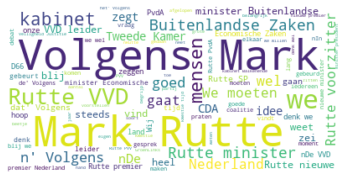

In [ ]:
cloudify(gen2text(sample_Vanilla))

## General

In [ ]:
sample_General = []
for i in tqdm(range(0, 10)):
  sample_General.extend(General("Volgens Mark Rutte", max_length=30, num_return_sequences=100))

100%|██████████| 10/10 [41:18<00:00, 247.86s/it]


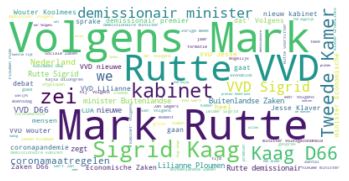

In [ ]:
cloudify(gen2text(sample_General))

## NRC

In [ ]:
sample_NRC = []
for i in tqdm(range(0, 10)):
  sample_NRC.extend(NRC("Volgens Mark Rutte", max_length=30, num_return_sequences=100))

100%|██████████| 10/10 [41:45<00:00, 250.50s/it]


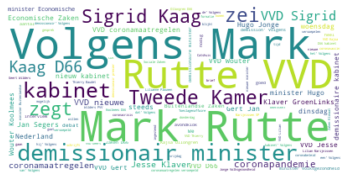

In [ ]:
cloudify(gen2text(sample_NRC))

## Volkskrant

In [ ]:
sample_Volkskrant = []
for i in tqdm(range(0, 10)):
  sample_Volkskrant.extend(Volkskrant("Volgens Mark Rutte", max_length=30, num_return_sequences=100))

100%|██████████| 10/10 [40:50<00:00, 245.05s/it]


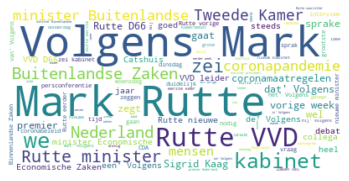

In [ ]:
cloudify(gen2text(sample_Volkskrant))

## Trouw

In [ ]:
sample_Trouw = []
for i in tqdm(range(0, 10)):
  sample_Trouw.extend(Trouw("Volgens Mark Rutte", max_length=30, num_return_sequences=100))

100%|██████████| 10/10 [40:58<00:00, 245.84s/it]


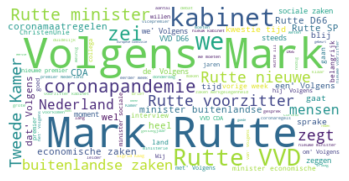

In [ ]:
cloudify(gen2text(sample_Trouw))

## HetParool

In [ ]:
sample_HetParool = []
for i in tqdm(range(0, 10)):
  sample_HetParool.extend(HetParool("Volgens Mark Rutte", max_length=30, num_return_sequences=100))

100%|██████████| 10/10 [41:14<00:00, 247.50s/it]


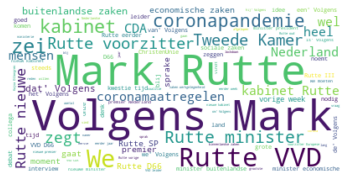

In [ ]:
cloudify(gen2text(sample_HetParool))

# Sample LDA Topic Modeling

In [119]:
def lda_analysis(texts, path_lda, topics=10):
  for text in texts:
    # Remove punctuation
    text = re.sub('[,\\.!?]', '', text)
    # Save D66
    text = re.sub('D66', 'dzeszes', text)
    # Save BIJ1
    text = re.sub('BIJ1', 'bijeeen', text)
    # Save 50PLUS
    text = re.sub('50PLUS', 'vijfplus', text)
    # Save JA21
    text = re.sub('JA21', 'jatweeeen', text)
    # Save DenHaan
    text = re.sub('Den Haan', 'denhaan', text)
    # Convert the titles to lowercase
    text = text.lower()

  stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo',
                     'we', 'wel', 'jaar', 'zegt', 'gaat','moeten', 'volgens',
                     'heel', 'maken', 'weer', 'gaan', 'twee', 'mensen', 'waar', 'alleen',
                     'komt', 'zoals', 'alle', 'wij', 'zei','komen','tussen', 'eerste','zien'
                     'eigen', 'leven','grote', 'nieuwe','mee','goed', 'aantal','laten'
                     ,'tweede', 'af', 'eerder', 'eigen', 'elkaar','afgelopen', 'week',
                     'zeggen', 'echt', 'dag', 'zien', 'steeds', 'laten', 'willen', 'waarin', 'corona', 'beleid'])

  def sent_to_words(texts):
      for text in texts:
          # deacc=True removes punctuations
          yield(gensim.utils.simple_preprocess(str(text), deacc=True))

  def remove_stopwords(text):
      return [[word for word in simple_preprocess(str(text)) 
              if word not in stop_words]for text in texts]

  data_words = sent_to_words(texts)# remove stop words

  data_words = remove_stopwords(texts)

  # Create Dictionary
  id2word = corpora.Dictionary(data_words)

  # Create Corpus
  texts = data_words

  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]

  # number of topics
  num_topics = topics
  # Build LDA model
  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics)
  pprint.pprint(lda_model.show_topics(num_words=20, formatted=False))
  doc_lda = lda_model[corpus]

  # Visualize the topics
  pyLDAvis.enable_notebook()
  LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
  LDAvis = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
  pyLDAvis.save_html(LDAvis, path_lda)

## General

In [122]:
sample_General = []
for i in tqdm(range(0, 500)):
  sample_General.extend(General("Het corona beleid", max_length=100, num_return_sequences=1))


100%|██████████| 500/500 [2:08:26<00:00, 15.41s/it]


In [123]:
general_sample = gen2text(sample_General)

In [124]:
print(general_sample[0])

Het corona beleid van premier Rutte heeft een �dringend effect� op het aantal nieuwe besmettingen. Dat schrijft. In totaal zijn er in de afgelopen zeven dagen zo�n 150 positieve coronatests binnengekomen bij GGD-opnames, blijkt uit cijfers die vrijdag naar buiten zijn opgevraagd. Het gaat om mensen tussen de 15 en 25 jaar; dat is meer dan duizend per dag.Volgens demissionair minister Hugo de Jonge (Volksgezondheid, CDA) maken we nu al snel duidelijk


In [126]:
lda_analysis(general_sample, 'drive/MyDrive/CS/Thesis/GPT2/LDA-coronabeleid.html', topics=5)

[(0,
  [('minister', 0.022195587),
   ('demissionair', 0.019542389),
   ('volksgezondheid', 0.017522562),
   ('jonge', 0.0161469),
   ('cda', 0.013861372),
   ('covid', 0.011666581),
   ('rutte', 0.011564649),
   ('hugo', 0.011396642),
   ('vvd', 0.009994756),
   ('gevaccineerd', 0.00961082),
   ('maatregelen', 0.009188669),
   ('kabinet', 0.0088275885),
   ('nederland', 0.0080991695),
   ('blijkt', 0.0078083053),
   ('premier', 0.0074834023),
   ('besmettingen', 0.0061723273),
   ('zaken', 0.0060166405),
   ('voorkomen', 0.0058820443),
   ('per', 0.005495228),
   ('tijdens', 0.0054746107)]),
 (1,
  [('demissionair', 0.019703534),
   ('jonge', 0.015681239),
   ('minister', 0.014137511),
   ('volksgezondheid', 0.013672858),
   ('hugo', 0.012776325),
   ('kabinet', 0.012426012),
   ('rutte', 0.011873632),
   ('cda', 0.011052725),
   ('maatregelen', 0.010939104),
   ('gevaccineerd', 0.01024095),
   ('premier', 0.008911871),
   ('besmettingen', 0.00880705),
   ('nederland', 0.008551971),
 

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [128]:
sample_NRC = []
for i in tqdm(range(0, 500)):
  sample_NRC.extend(NRC("Het corona beleid", max_length=100, num_return_sequences=1))


 57%|█████▋    | 285/500 [1:16:47<57:56, 16.17s/it]


KeyboardInterrupt: ignored

In [ ]:
general_sample = gen2text(sample_NRC)

In [ ]:
print(general_sample[0])

In [ ]:
lda_analysis(general_sample, 'drive/MyDrive/CS/Thesis/GPT2/LDA-coronabeleid-NRC.html', topics=5)